In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn import set_config 
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

from sklearn.metrics import root_mean_squared_error, r2_score

import optuna
from optbinning import ContinuousOptimalBinning

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

import pickle
import json
import os

import warnings
warnings.simplefilter('ignore')

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(CVXPY) Feb 20 08:06:44 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 20 08:06:44 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# config global setting so that all transformers return pandas in the output
set_config(transform_output='pandas')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# set random seed
RANDOM_SEED = 42

tf.random.set_seed(RANDOM_SEED) 

## Load data

In [5]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

df = pd.concat([df_train, df_test], axis=0)

In [6]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [7]:
df.shape

(2919, 81)

## Create extra variables

In [8]:
def create_new_variables(df):
    ## Basement SF
    df['BsmtUnfSF_to_TotalBsmtSF'] = df['BsmtUnfSF'] / df['TotalBsmtSF']
    df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
    df['BsmtFinSF_to_TotalBsmtSF'] = df['BsmtFinSF'] / df['TotalBsmtSF']
    df['TotalBsmtSF_to_LotArea'] = df['TotalBsmtSF'] / df['LotArea']

    ## 1st floor + 2nd floor
    df['FlrSF'] = df['1stFlrSF'] + df['2ndFlrSF']
    # df['1stFlrSF_to_2ndFlrSF'] = df['1stFlrSF'] / df['2ndFlrSF']
    df['LowQualFinSF_to_FlrSF'] = df['LowQualFinSF'] / df['FlrSF']
    df['LowQualFinSF_to_GrLivArea'] = df['LowQualFinSF'] / df['GrLivArea']
    df['GrLivArea_to_FlrSF'] = df['GrLivArea'] / df['FlrSF']
    df['GrLivArea_to_LotArea'] = df['GrLivArea'] / df['LotArea']

    ## Bathrooms
    df['BsmtBath_Total'] = df['BsmtFullBath'] + df['BsmtHalfBath']
    df['AbvGrBath_Total'] = df['FullBath'] + df['HalfBath']
    df['AbvGrRoom_Total'] = df['TotRmsAbvGrd'] + df['AbvGrBath_Total']

    ## Bedroom & Kitchen
    df['BedroomAbvGr_to_AbvGrRoom_Total'] = df['BedroomAbvGr'] / df['AbvGrRoom_Total']
    df['KitchenAbvGr_to_AbvGrRoom_Total'] = df['KitchenAbvGr'] / df['AbvGrRoom_Total']

    ## Porch
    df['PorchSF_Total'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch']

    ## Garage
    df['GarageArea_to_GarageCars'] = df['GarageArea'] / df['GarageCars']

    ## Quarter Sold
    df['QuSold'] = df['MoSold'].apply(lambda x: (x - 1) // 3 + 1)

    return df

In [9]:
df = create_new_variables(df)

## Separate train and test data

In [10]:
# target variable
target = 'SalePrice'

In [11]:
# separate into train and test set
X_train = df[~df[target].isnull()].drop(target, axis=1)
y_train = df[~df[target].isnull()][target]
X_test = df[df[target].isnull()].drop(target, axis=1)
y_test = df[df[target].isnull()][target]

In [12]:
X_train.shape, X_test.shape

((1460, 97), (1459, 97))

In [13]:
# drop column id
X_train.drop('Id', axis=1, inplace=True)
X_test.drop('Id', axis=1, inplace=True)

## EDA

### 1. Target variable

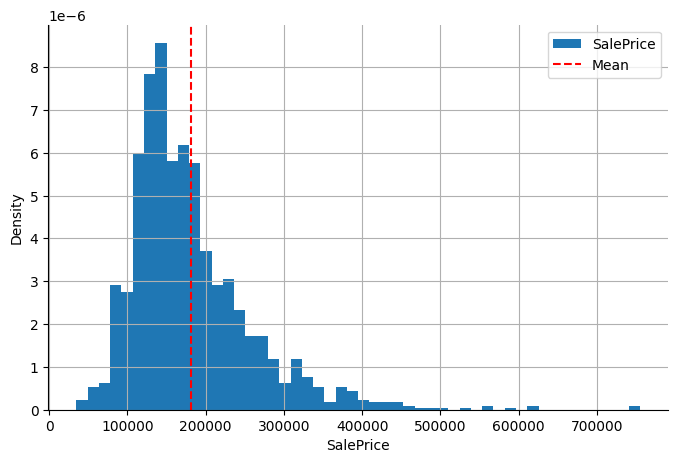

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
y_train.plot.hist(bins=50, density=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(target)
ax.set_ylabel('Density')
# ax.grid(True)
ax.axvline(y_train.mean(), ls='--', c='r', label='Mean')
ax.legend()
ax.grid(True)
plt.show()

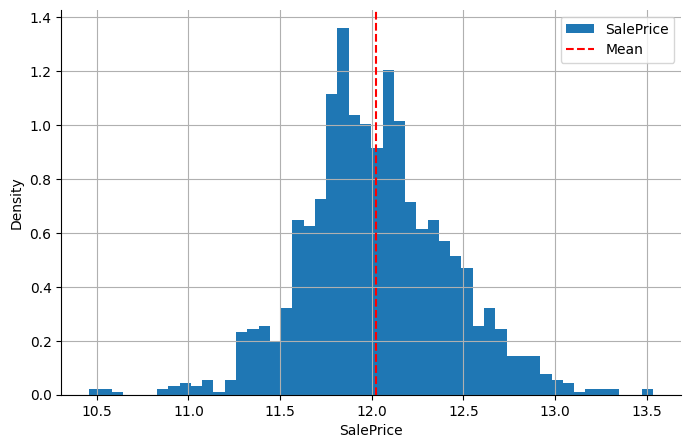

In [15]:
# apply log transformation to the target distribution
fig, ax = plt.subplots(figsize=(8,5))
np.log(y_train).plot.hist(bins=50, density=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(target)
ax.set_ylabel('Density')
# ax.grid(True)
ax.axvline(np.log(y_train).mean(), ls='--', c='r', label='Mean')
ax.legend()
ax.grid(True)
plt.show()

In [16]:
# apply the log transformation on the target
y_train = y_train.apply(np.log)
y_test = y_test.apply(np.log)

### 2. Separate numerical and categorical variables

In [17]:
# separate the categorical and numerical variables
CAT_VARS = [col for col in X_train.columns if X_train[col].dtype=='O'] + ['MSSubClass']
NUM_VARS = [col for col in X_train.columns if col not in CAT_VARS]

# cast all variables in CAT_VARS as object
X_train[CAT_VARS] = X_train[CAT_VARS].astype('O')
X_test[CAT_VARS] = X_test[CAT_VARS].astype('O')

# check number of variables
print(f'Number of categorical variables: {len(CAT_VARS)}')
print(f'Number of numerical variables: {len(NUM_VARS)}')

Number of categorical variables: 44
Number of numerical variables: 52


In [18]:
# create a config dictionary for later use
CONFIG = {}
CONFIG['NUM_VARS'] = NUM_VARS
CONFIG['CAT_VARS'] = CAT_VARS

In [19]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.000000,59.000000,69.000000,80.000000,313.000000
LotArea,1460.0,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.000000
OverallQual,1460.0,6.099315,1.382997,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,1460.0,5.575342,1.112799,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,1460.0,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000
YearRemodAdd,1460.0,1984.865753,20.645407,1950.000000,1967.000000,1994.000000,2004.000000,2010.000000
MasVnrArea,1452.0,103.685262,181.066207,0.000000,0.000000,0.000000,166.000000,1600.000000
BsmtFinSF1,1460.0,443.639726,456.098091,0.000000,0.000000,383.500000,712.250000,5644.000000
BsmtFinSF2,1460.0,46.549315,161.319273,0.000000,0.000000,0.000000,0.000000,1474.000000
BsmtUnfSF,1460.0,567.240411,441.866955,0.000000,223.000000,477.500000,808.000000,2336.000000


### 3. Missing values

In [20]:
# check whether variables with NA are from categorical or numerical vars
NUM_NA = [col for col in NUM_VARS if X_train[col].isnull().any()]
CAT_NA = [col for col in CAT_VARS if X_train[col].isnull().any()]

print(f'Number of numerical variables with missing values: {len(NUM_NA)}')
print(f'Number of categorical variables with missing values: {len(CAT_NA)}')

Number of numerical variables with missing values: 6
Number of categorical variables with missing values: 16


In [21]:
CONFIG['NUM_NA'] = NUM_NA
CONFIG['CAT_NA'] = CAT_NA

In [22]:
# check the relationship between sale price and missing variables
def check_saleprice_na_vars(X, y, var):
    X_ = X.copy()
    # create an indicator column for flagging missing values
    X_[f'{var}'] = np.where(X_[var].isnull(), 1, 0)
    # compare the mean SalePrice in the observations where data is missing vs the observations where data is available
    tmp = pd.concat([X_, y.apply(np.exp)], axis=1).groupby(f'{var}')[target].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Sale Price", color='green')

    plt.show()

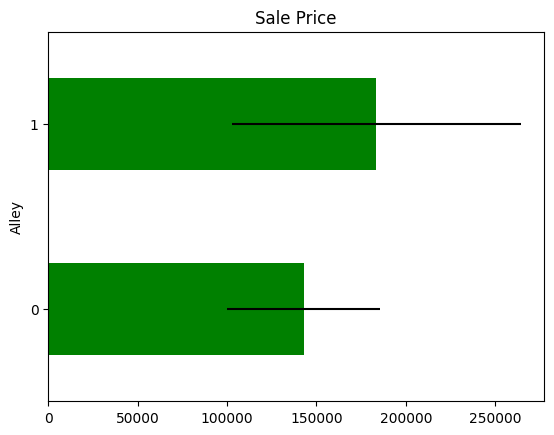

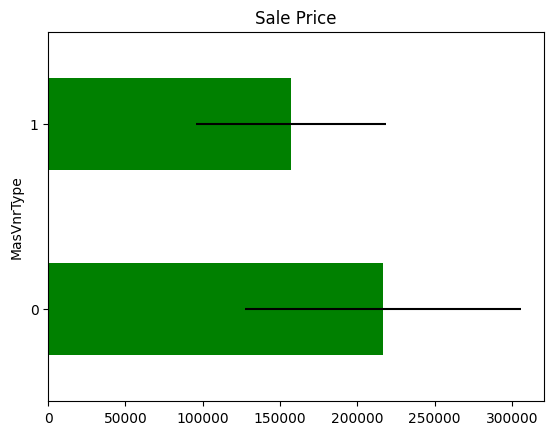

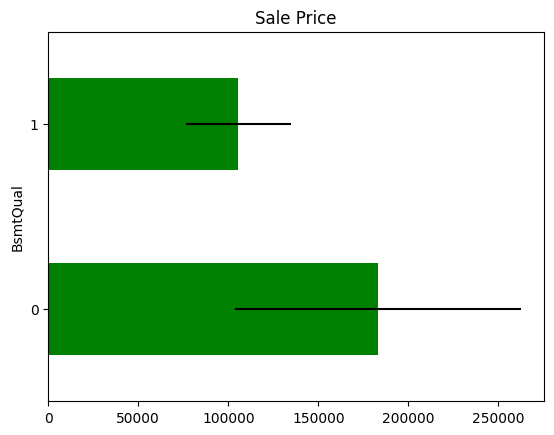

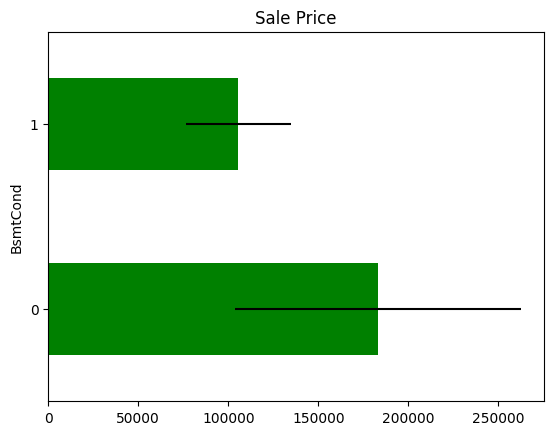

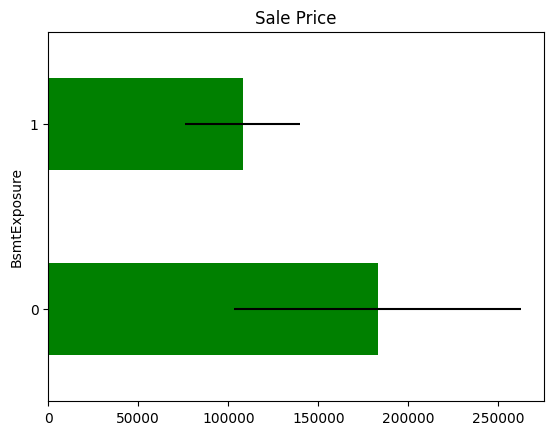

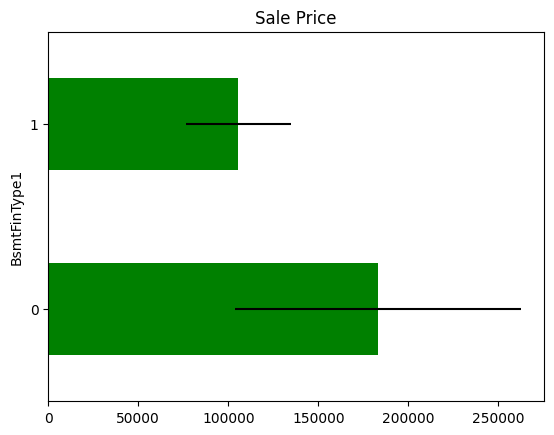

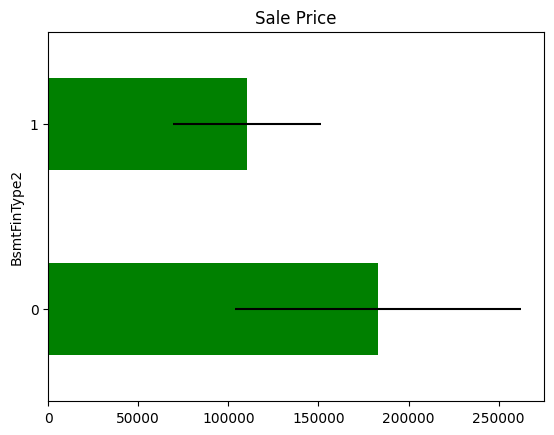

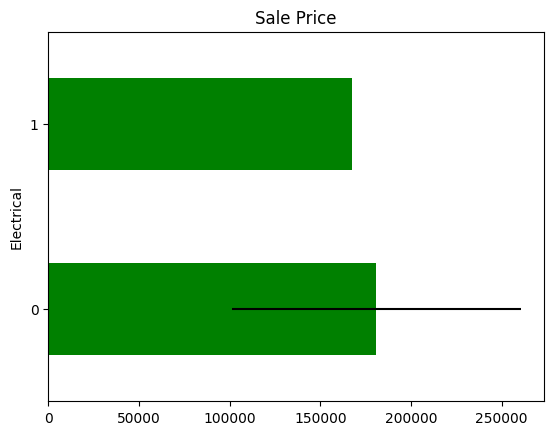

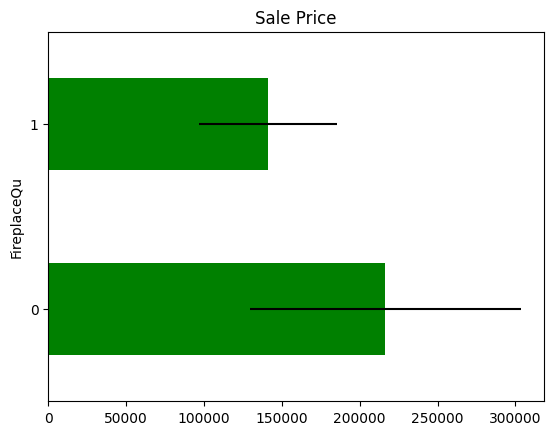

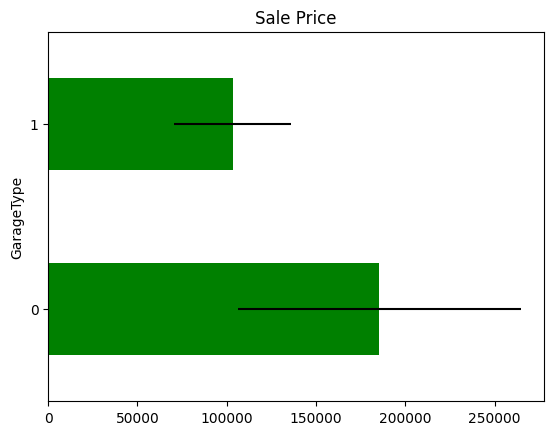

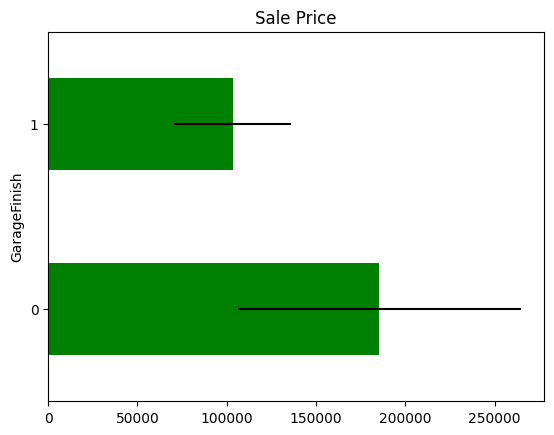

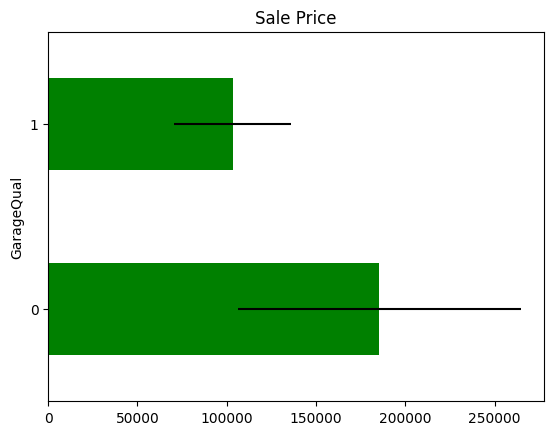

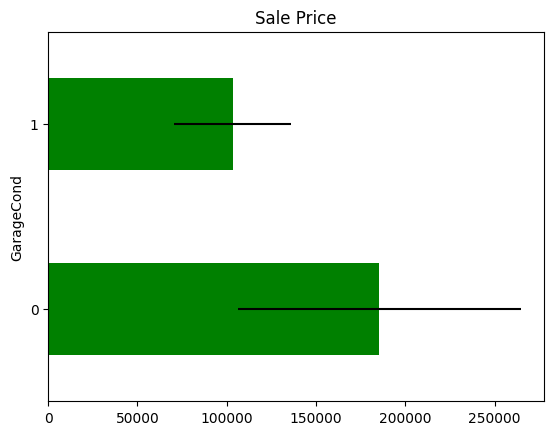

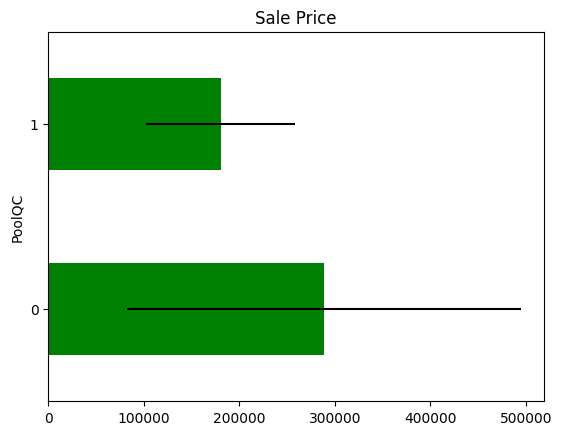

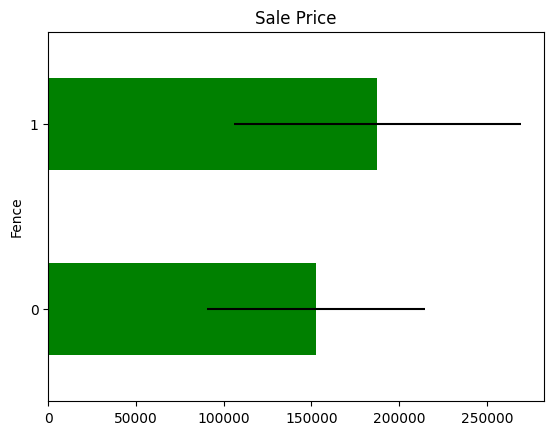

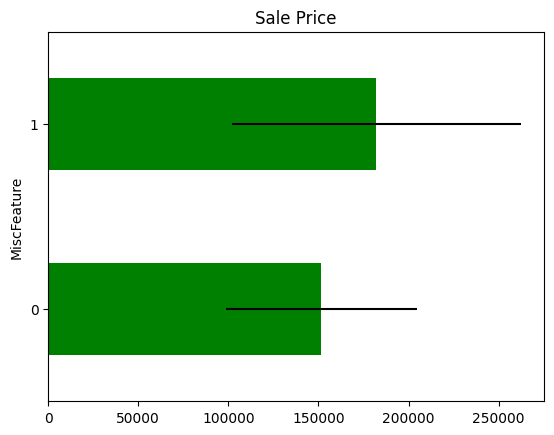

In [23]:
for var in CAT_NA:
    check_saleprice_na_vars(X_train, y_train, var)

In some categorical variables, the average Sale Price in houses where the information is missing, differs from the average Sale Price in houses where information exists. This suggests that data being missing could be a good predictor of Sale Price.

In [24]:
# variables to impute with 'missing' flag for variables with more than 10% missing data
IMPUTE_WITH_MISSING_STR = [col for col in CAT_NA if X_train[col].isnull().mean() > 0.1]

# variables to impute with most frequent category for variables with <= 10% missing
IMPUTE_WITH_FREQUENT_CAT = [col for col in CAT_NA if X_train[col].isnull().mean() <= 0.1]

In [25]:
# IMPUTE_WITH_MISSING_STR
CONFIG['IMPUTE_WITH_MISSING_STR'] = IMPUTE_WITH_MISSING_STR
CONFIG['IMPUTE_WITH_FREQUENT_CAT'] = IMPUTE_WITH_FREQUENT_CAT

In [26]:
# check out the most frequent categories 
for var in IMPUTE_WITH_FREQUENT_CAT:
    mode_ = X_train[var].mode()[0]
    print(var, mode_)

BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
Electrical SBrkr
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA


In [27]:
# check % of missing data of numerical variables
X_train[NUM_NA].isnull().mean()

LotFrontage                 0.177397
MasVnrArea                  0.005479
GarageYrBlt                 0.055479
BsmtUnfSF_to_TotalBsmtSF    0.025342
BsmtFinSF_to_TotalBsmtSF    0.025342
GarageArea_to_GarageCars    0.055479
dtype: float64

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'MasVnrArea'}>],
       [<Axes: title={'center': 'GarageYrBlt'}>,
        <Axes: title={'center': 'BsmtUnfSF_to_TotalBsmtSF'}>],
       [<Axes: title={'center': 'BsmtFinSF_to_TotalBsmtSF'}>,
        <Axes: title={'center': 'GarageArea_to_GarageCars'}>]],
      dtype=object)

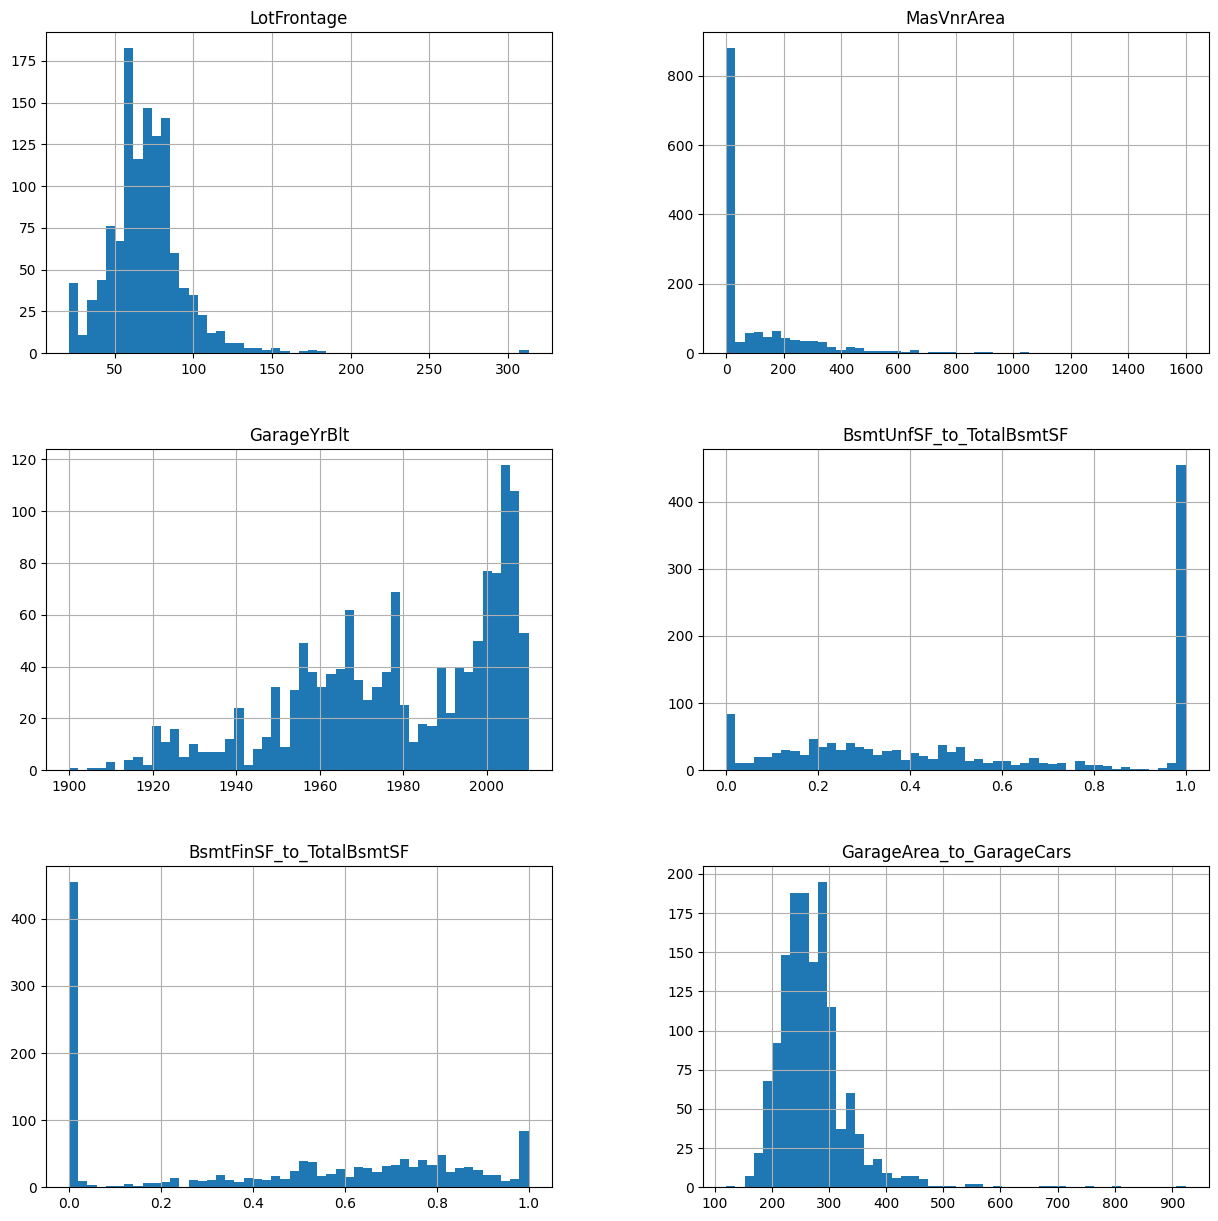

In [28]:
# check distribution of numerical variables with missing values
X_train[NUM_NA].hist(bins=50, figsize=(15, 15))

In [29]:
# since the distribution of these variables are not normal.
# we'll impute with the median
IMPUTE_WITH_MEDIAN = NUM_NA

CONFIG['IMPUTE_WITH_MEDIAN'] = IMPUTE_WITH_MEDIAN

### 4. Temporal variables

In [30]:
# list of year variables in the dataset
YEAR_VARS = [col for col in X_train.columns if 'Yr' in col or 'Year' in col]

YEAR_VARS

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [31]:
CONFIG['YEAR_VARS'] = YEAR_VARS

In [32]:
X_train[YEAR_VARS].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


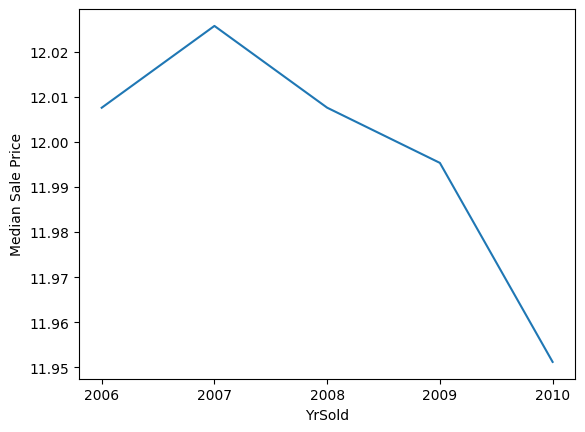

In [33]:
# median sale price in relation with year sold
pd.concat([X_train, y_train], axis=1).groupby('YrSold')[target].median().plot()
plt.ylabel('Median Sale Price')
plt.xticks(range(X_train['YrSold'].min(), X_train['YrSold'].max()+1))
plt.show()

There seems to be a downward trend in the median house price, which is unusual as house prices tend to go up over time.

Let's also check the Sale Price in relation to the year in which the house was built.

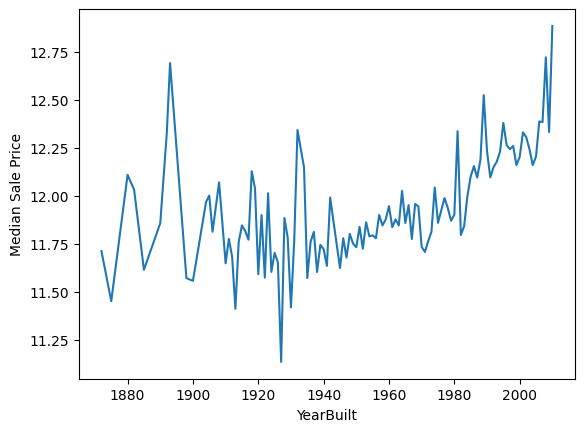

In [34]:
# median sale price vs. year built
pd.concat([X_train, y_train], axis=1).groupby('YearBuilt')[target].median().plot()
plt.ylabel('Median Sale Price')
# plt.xticks(range(X_train['YearBuilt'].min(), X_train['YearBuilt'].max()+1))
plt.show()

Newly built/younger houses tend to be more expensive. 

Perhaps more older houses are being sold in more recent years?

We can calculate the elapsed years between the time the house was built vs. when it was sold / remodeled

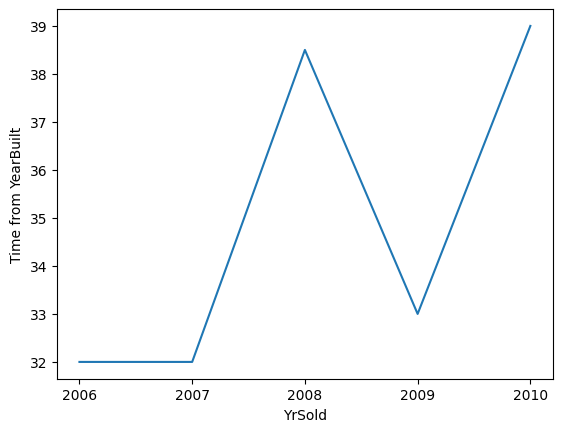

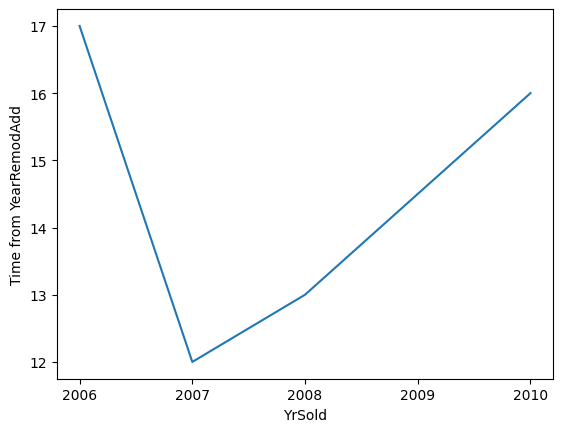

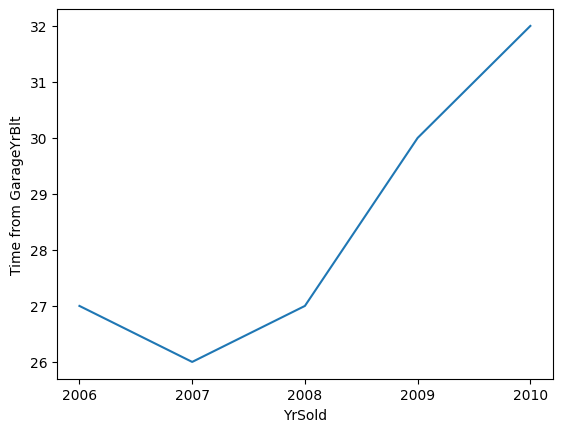

In [35]:
def check_year_vars(X, y, var):
    X_ = X.copy()
    # calculate difference between YrSold and year in which house was built / remodeled
    X_[var] = X_['YrSold'] - X_[var]
    
    pd.concat([X_, y], axis=1).groupby('YrSold')[var].median().plot()
    plt.ylabel(f'Time from {var}')
    plt.xticks(range(X_train['YrSold'].min(), X_train['YrSold'].max()+1))
    plt.show()

for col in YEAR_VARS:
    if col != 'YrSold':
        check_year_vars(X_train, y_train, col)

We can see that towards recent years, the houses sold tend to have older garages, and had not been remodeled recently, which might explain why we see cheaper sale prices in recent years.

### 5. Discrete variables

In [36]:
# check number of unique values in each numerical variables
X_train[NUM_VARS].nunique().sort_values(ascending=False)

GrLivArea_to_LotArea               1423
TotalBsmtSF_to_LotArea             1383
LotArea                            1073
BsmtUnfSF_to_TotalBsmtSF            879
BsmtFinSF_to_TotalBsmtSF            879
FlrSF                               862
GrLivArea                           861
BsmtUnfSF                           780
1stFlrSF                            753
TotalBsmtSF                         721
BsmtFinSF1                          637
BsmtFinSF                           637
GarageArea                          441
2ndFlrSF                            417
GarageArea_to_GarageCars            383
MasVnrArea                          327
WoodDeckSF                          274
PorchSF_Total                       261
OpenPorchSF                         202
BsmtFinSF2                          144
EnclosedPorch                       120
YearBuilt                           112
LotFrontage                         110
GarageYrBlt                          97
ScreenPorch                          76


In [37]:
# we could consider variables with less than 20 unique values discrete variables
DISCRETE_VARS = [col for col in NUM_VARS if X_train[col].nunique() < 20 and col not in YEAR_VARS+['PoolArea', '3SsnPorch', 'MiscVal']]

print(f'Number of discrete variables: {len(DISCRETE_VARS)}')

Number of discrete variables: 16


In [38]:
X_train[DISCRETE_VARS].head()

,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,MoSold,BsmtBath_Total,AbvGrBath_Total,AbvGrRoom_Total,QuSold
0,7,5,1.0,0.0,2,1,3,1,8,0,2.0,2,1.0,3,11,1
1,6,8,0.0,1.0,2,0,3,1,6,1,2.0,5,1.0,2,8,2
2,7,5,1.0,0.0,2,1,3,1,6,1,2.0,9,1.0,3,9,3
3,7,5,1.0,0.0,1,0,3,1,7,1,3.0,2,1.0,1,8,1
4,8,5,1.0,0.0,2,1,4,1,9,1,3.0,12,1.0,3,12,4


These discrete variables tend to be qualifications or grading scales, or refer to number of rooms / units, or area of the room.

Let's see their relationship to the Sale price

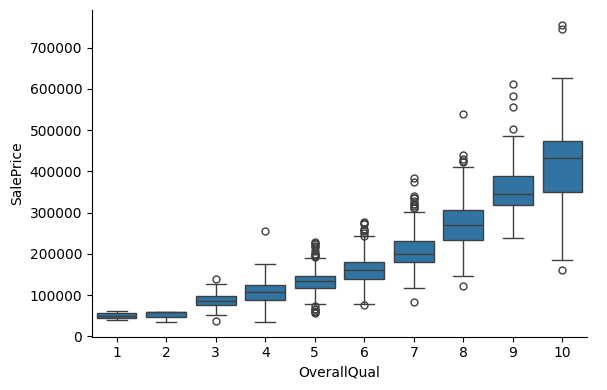

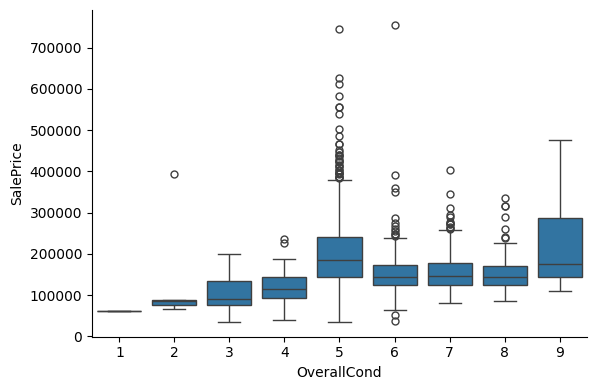

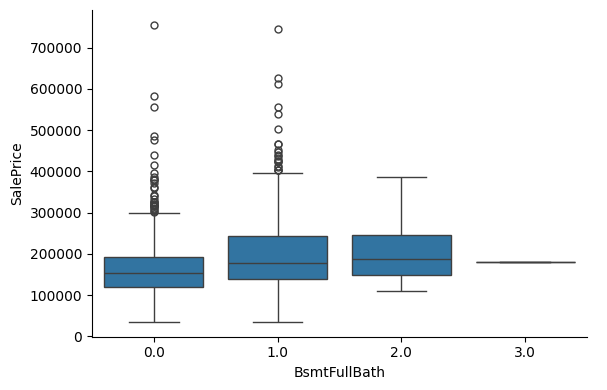

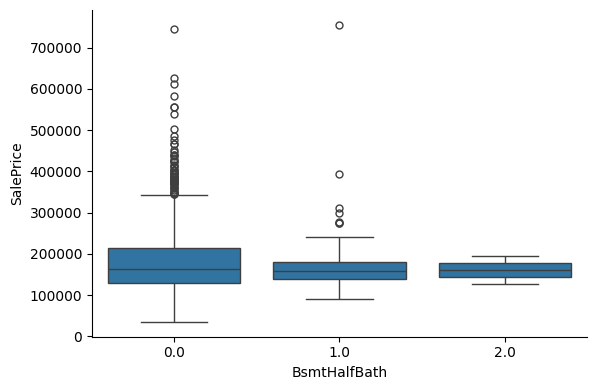

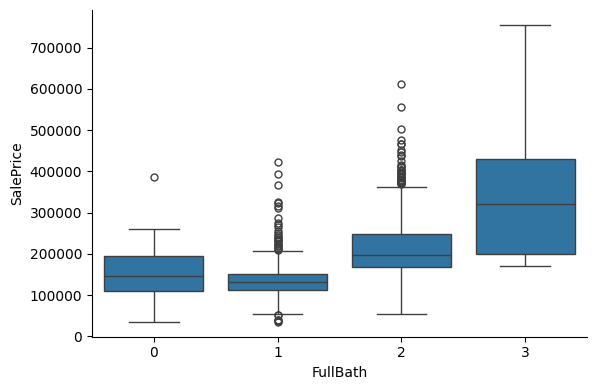

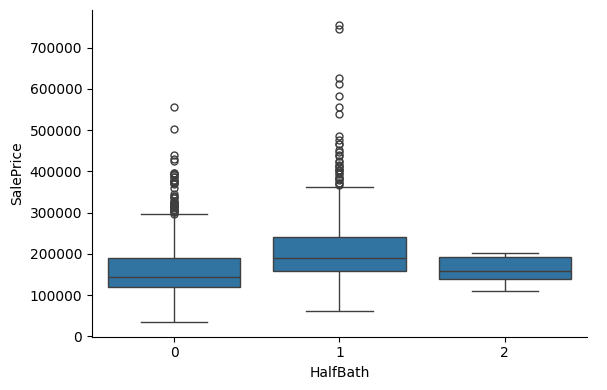

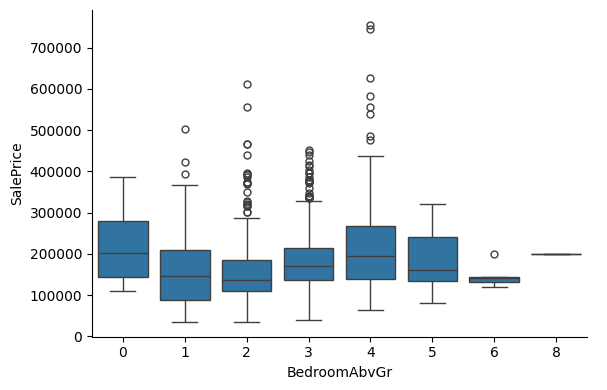

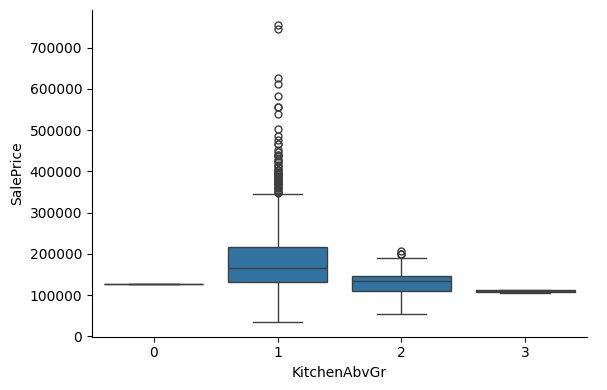

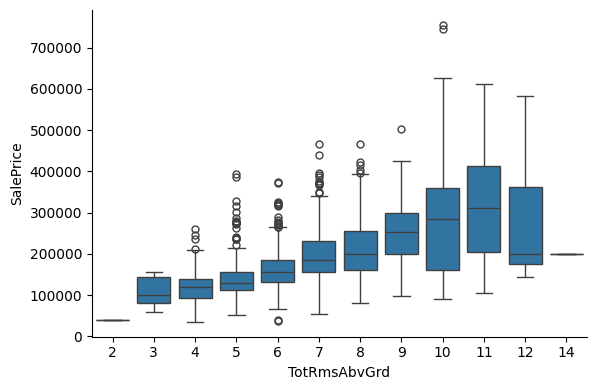

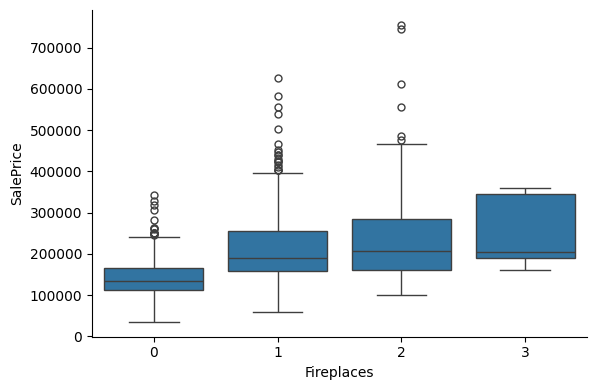

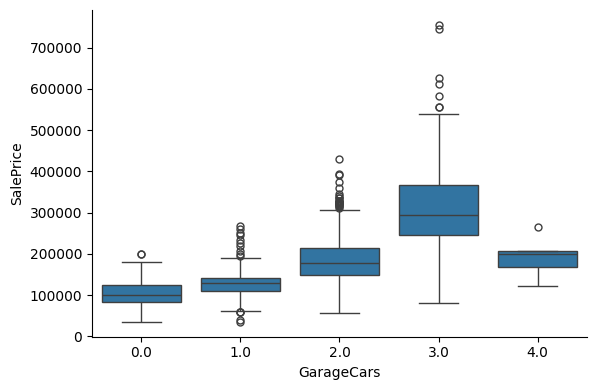

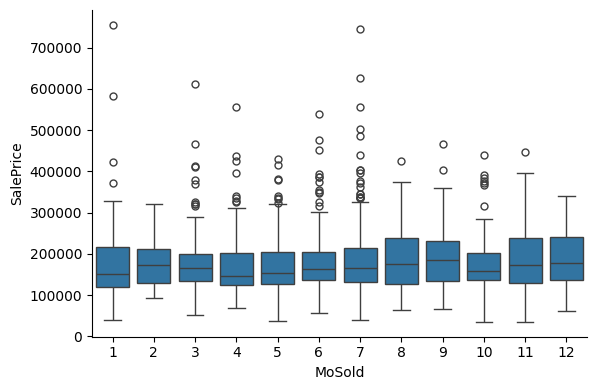

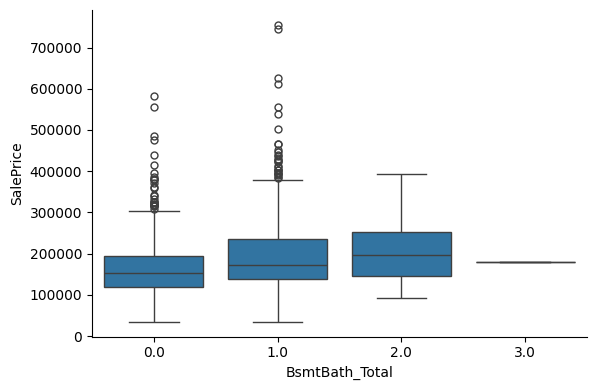

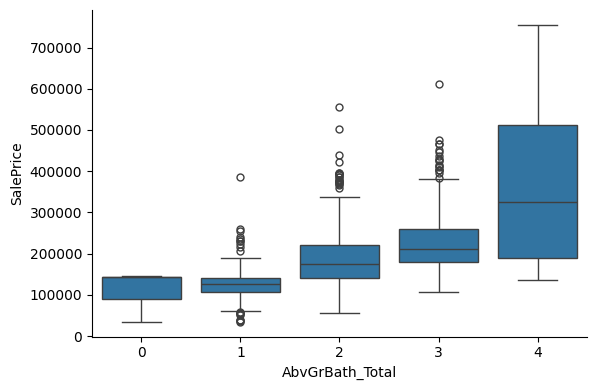

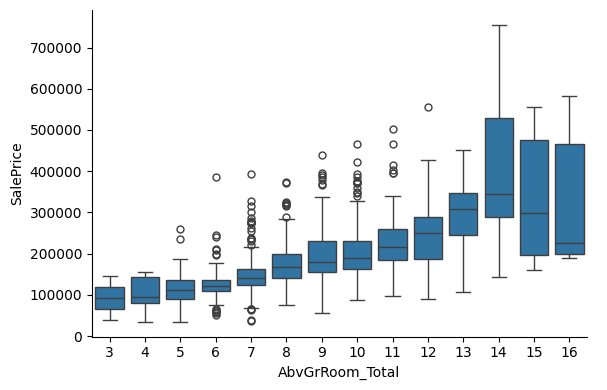

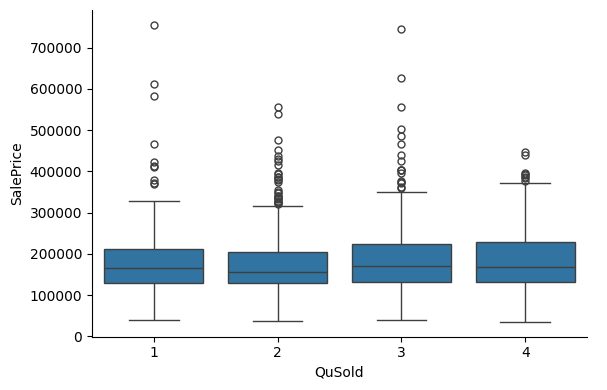

In [39]:
for var in DISCRETE_VARS:
    sns.catplot(x=var, y=target, data=pd.concat([X_train, y_train.apply(np.exp)], axis=1),
                kind='box', height=4, aspect=1.5)
    # add data points to box
    plt.show()

In [40]:
CONFIG['DISCRETE_VARS'] = DISCRETE_VARS

### 6. Continuous variables

In [41]:
# find continuous variables
CONT_VARS = [col for col in NUM_VARS if col not in DISCRETE_VARS+YEAR_VARS]

print(f'Number of continuous variables: {len(CONT_VARS)}')

Number of continuous variables: 32


In [42]:
CONFIG['CONT_VARS'] = CONT_VARS

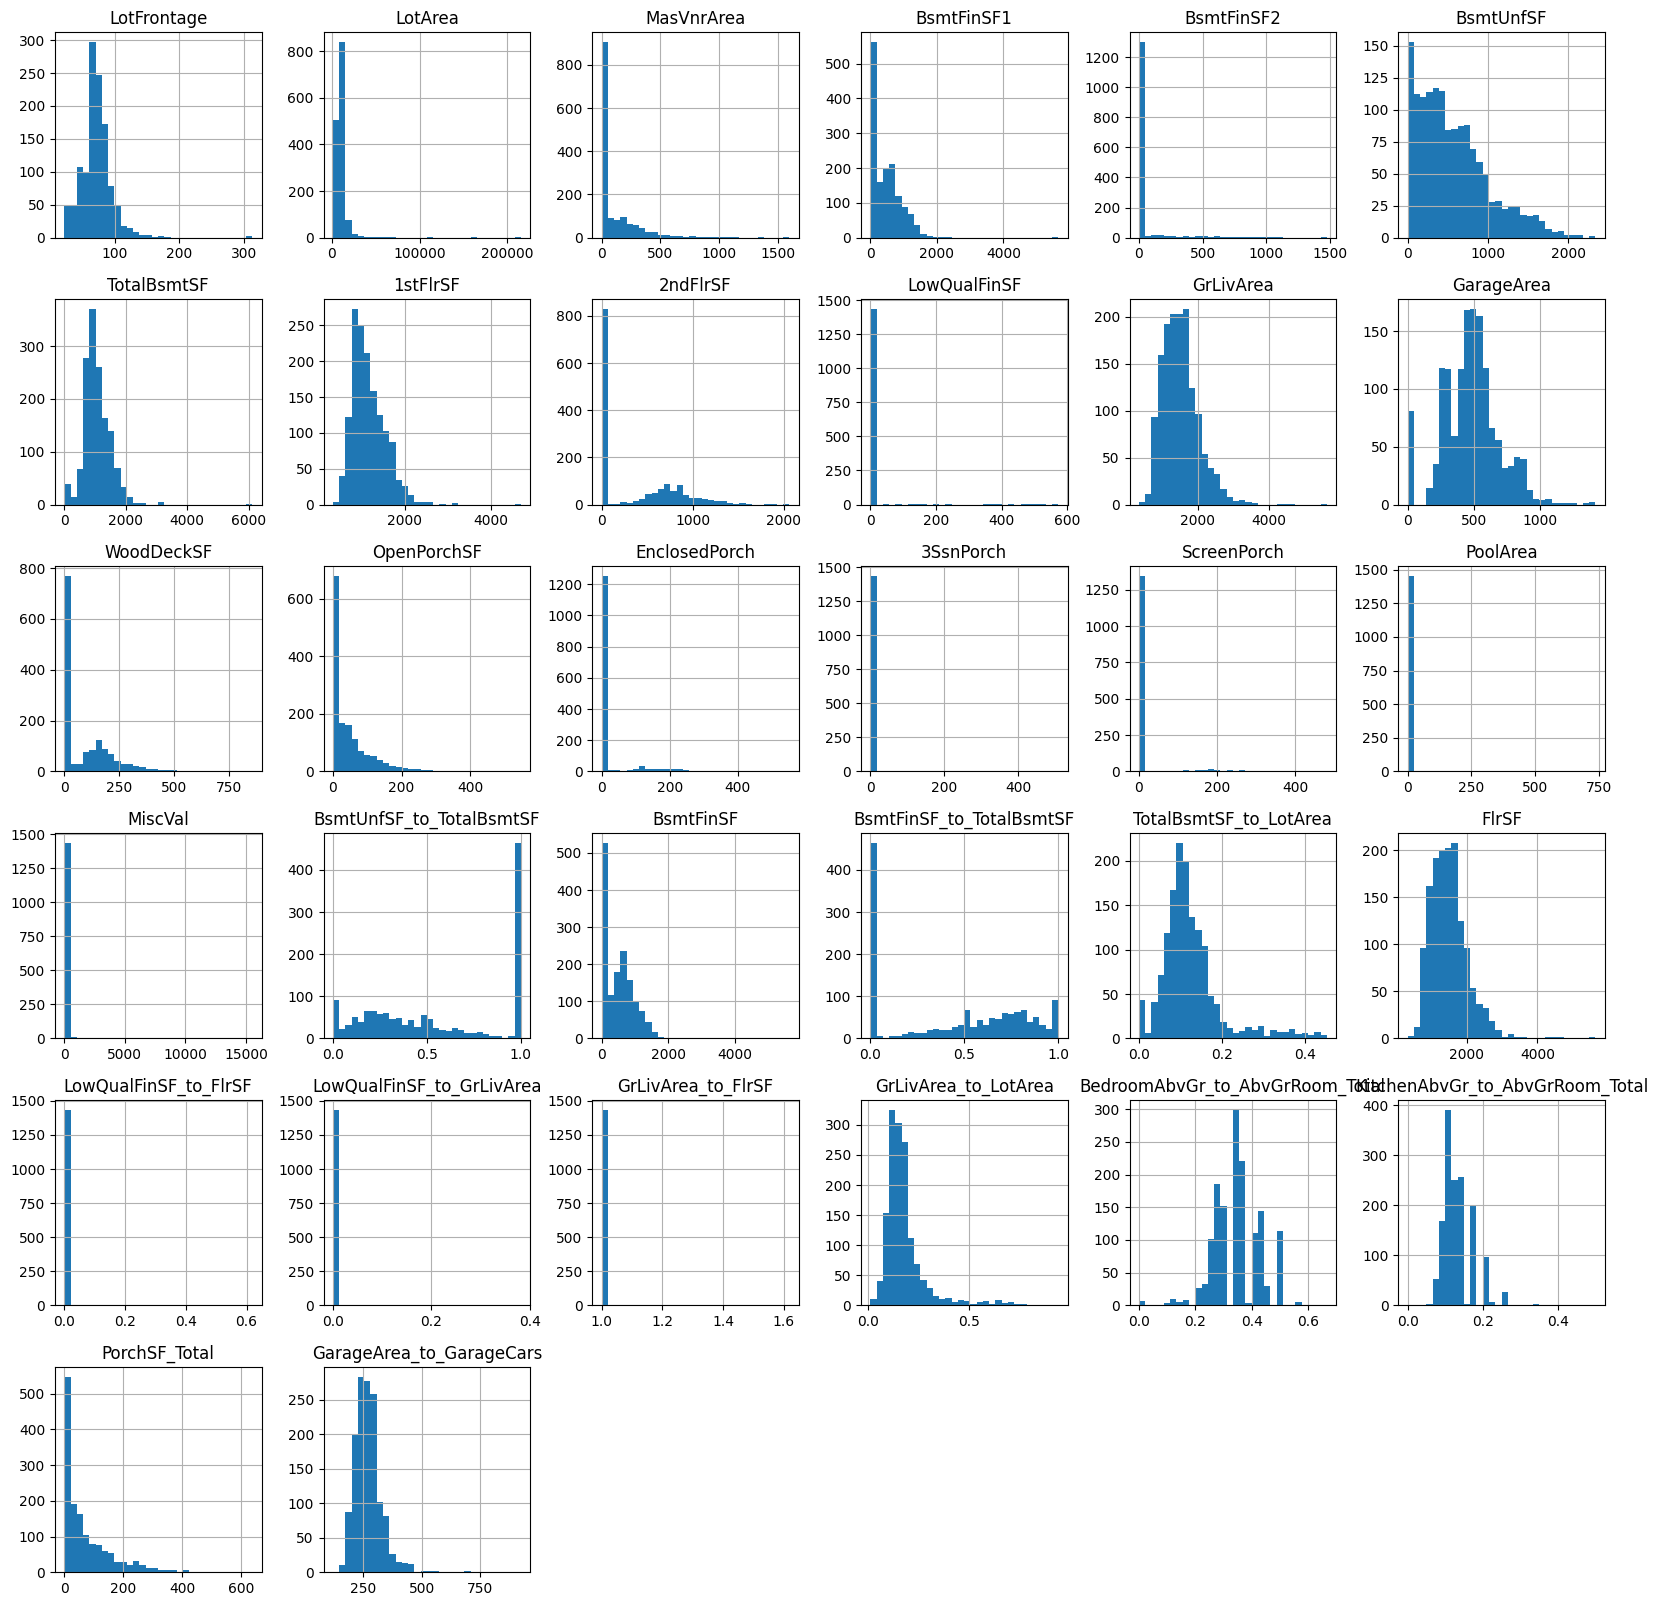

In [43]:
# visualize the distribution of continuous variables
X_train[CONT_VARS].hist(bins=30, figsize=(20, 20))
plt.show()

In [44]:
# separate the ratio vars
RATIO_VARS = [col for col in CONT_VARS if '_to_' in col]
RATIO_VARS

['BsmtUnfSF_to_TotalBsmtSF',
 'BsmtFinSF_to_TotalBsmtSF',
 'TotalBsmtSF_to_LotArea',
 'LowQualFinSF_to_FlrSF',
 'LowQualFinSF_to_GrLivArea',
 'GrLivArea_to_FlrSF',
 'GrLivArea_to_LotArea',
 'BedroomAbvGr_to_AbvGrRoom_Total',
 'KitchenAbvGr_to_AbvGrRoom_Total',
 'GarageArea_to_GarageCars']

In [45]:
CONFIG['RATIO_VARS'] = RATIO_VARS

In [46]:
# check out the skew measure of the continuous variables
# we'll need to apply some log transformation to the highly skewed variables
# to make the distribution more normal like
X_train[CONT_VARS].skew().sort_values(ascending=False)

MiscVal                            24.476794
PoolArea                           14.828374
LotArea                            12.207688
LowQualFinSF_to_FlrSF              10.753543
GrLivArea_to_FlrSF                 10.753543
3SsnPorch                          10.304342
LowQualFinSF_to_GrLivArea           9.738052
LowQualFinSF                        9.011341
BsmtFinSF2                          4.255261
ScreenPorch                         4.122214
EnclosedPorch                       3.089872
GarageArea_to_GarageCars            2.876574
GrLivArea_to_LotArea                2.847162
MasVnrArea                          2.669084
OpenPorchSF                         2.364342
LotFrontage                         2.163569
PorchSF_Total                       1.818333
TotalBsmtSF_to_LotArea              1.816171
BsmtFinSF1                          1.685503
KitchenAbvGr_to_AbvGrRoom_Total     1.562173
WoodDeckSF                          1.541376
TotalBsmtSF                         1.524255
BsmtFinSF 

In [47]:
SKEWED_VARS = [col for col in CONT_VARS if X_train[col].skew() > 3 and col not in RATIO_VARS]
SKEWED_VARS

['LotArea',
 'BsmtFinSF2',
 'LowQualFinSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [48]:
CONFIG['SKEWED_VARS'] = SKEWED_VARS

In [49]:
# remaining continuous variables
CONT_VARS = [col for col in CONT_VARS if col not in SKEWED_VARS and col not in RATIO_VARS]

CONFIG['CONT_VARS'] = CONT_VARS

### 7. Categorical variables

#### 7.1. Ordinal variables & mappings

In [50]:
# collect a list of quality variables
QUAL_VARS = [col for col in CAT_VARS if ('Qual'in col or 'Cond' in col or 'QC' in col) and 'Condition' not in col]
QUAL_VARS

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'GarageQual',
 'GarageCond',
 'PoolQC']

In [51]:
CONFIG['QUAL_VARS'] = QUAL_VARS

The mappings of values reflecting quality and condition can be obtained from the Kaggle Website. One example:

- Ex = Excellent
- Gd = Good
- TA = Average/Typical
- Fa =	Fair
- Po = Poor

In [52]:
# create mappings for quality conditions
QUAL_MAPPINGS = {
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    'Missing': -1,
    'NA': -1,
    np.nan: -1,
}

CONFIG['QUAL_MAPPINGS'] = QUAL_MAPPINGS

In [53]:
# LotShape
LOT_SHAPE_MAPPINGS = {
    'IR3': 1,   # irregular
    'IR2': 2,   # moderately irregular
    'IR1': 3,   # slightly irregular
    'Reg': 4,   # regular
    'Missing': -1,
    'NA': -1,
    np.nan: -1,
}

CONFIG['LOT_SHAPE_MAPPINGS'] = LOT_SHAPE_MAPPINGS

In [54]:
# Utilities
UTIL_MAPPINGS = {
    'ELO': 1,       # electricity only
    'NoSeWa': 2,    # electricity & gas only
    'NoSewr': 3,    # electricity, gas & water
    'AllPub': 4,    # all public utilities (E,G,W,S)
    'Missing': -1,
    'NA': -1,  
    np.nan: -1,    
}

CONFIG['UTIL_MAPPINGS'] = UTIL_MAPPINGS

In [55]:
# LandSlope
SLOPE_MAPPINGS = {
    'Gtl': 1,   # gentle slope
    'Mod': 2,   # moderate slope
    'Sev': 3,   # severe slope
    'Missing': -1,
    'NA': -1,
    np.nan: -1,
}

CONFIG['SLOPE_MAPPINGS'] = SLOPE_MAPPINGS

In [56]:
# BsmtExposure
EXPOSURE_MAPPINGS = {
    'No': 1,    # no exposure
    'Mn': 2,    # minimum exposure
    'Av': 3,    # average exposure
    'Gd': 4,    # good exposure
    'Missing': -1,
    'NA': -1,    
    np.nan: -1,
}

CONFIG['EXPOSURE_MAPPINGS'] = EXPOSURE_MAPPINGS

In [57]:
# finish variables
FINISH_VARS = ['BsmtFinType1', 'BsmtFinType2']
CONFIG['FINISH_VARS'] = FINISH_VARS

FINISH_MAPPINGS = {
    'Unf': 1,   # unfinished
    'LwQ': 2,   # low quality
    'Rec': 3,   # Average rec room
    'BLQ': 4,   # below average living quarters
    'ALQ': 5,   # average living quarters
    'GLQ': 6,   # good living quarters
    'Missing': -1,
    'NA': -1,
    np.nan: -1
}
CONFIG['FINISH_MAPPINGS'] = FINISH_MAPPINGS

In [58]:
# Functional
FUNCTION_MAPPINGS = {
    'Sal': 1,       # salvage only
    'Sev': 2,       # severely damaged
    'Maj2': 3,      # major deductions 2
    'Maj1': 4,      # major deductions 1
    'Mod': 5,       # moderate deductions    
    'Min2': 6,      # minor deductions 2
    'Min1': 7,      # minor deductions 1
    'Typ': 8,       # typical functionality
    'Missing': -1,
    'NA': -1,
    np.nan: -1,
}

CONFIG['FUNCTION_MAPPINGS'] = FUNCTION_MAPPINGS

In [59]:
# GarageFinish
GARAGE_MAPPINGS = {
    'NA': 0,    # no garage
    'Missing': -1,
    'Unf': 1,   # unfinished
    'RFn': 2,   # rough finish
    'Fin': 3,   # finished
    np.nan: -1
}

CONFIG['GARAGE_MAPPINGS'] = GARAGE_MAPPINGS

In [60]:
# Fence
FENCE_MAPPINGS = {
    'NA': 0,    # no fence
    'Missing': -1,
    'MnWw': 1,  # minimum wood/wire
    'GdWo': 2,  # good Wood
    'MnPrv': 3, # minimum privacy
    'GdPrv': 4, # good privacy
    np.nan: -1,
}

CONFIG['FENCE_MAPPINGS'] = FENCE_MAPPINGS

In [61]:
# all the quality variables
ORDINAL_VARS = QUAL_VARS + FINISH_VARS + ['LotShape', 'Utilities', 'LandSlope', 'BsmtExposure', 'Functional', 'GarageFinish', 'Fence']

CONFIG['ORDINAL_VARS'] = ORDINAL_VARS

#### 7.2. Remaining variables - Rare labels

In [62]:
CAT_OTHERS = [col for col in CAT_VARS if col not in ORDINAL_VARS]

In [63]:
len(CAT_OTHERS)

26

In [64]:
def check_rare_labels(df, var, rare_perc):
    df_ = df.copy()
    tmp = df_[var].value_counts(normalize=True)
    return tmp[tmp < rare_perc]

# check for rare categories that are present in < 1% observations
for var in CAT_OTHERS:
    print(check_rare_labels(X_train, var, 0.01))
    print()

MSZoning
C (all)    0.006849
Name: proportion, dtype: float64

Street
Grvl    0.00411
Name: proportion, dtype: float64

Series([], Name: proportion, dtype: float64)

Series([], Name: proportion, dtype: float64)

LotConfig
FR3    0.00274
Name: proportion, dtype: float64

Neighborhood
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: proportion, dtype: float64

Condition1
RRAe    0.007534
PosA    0.005479
RRNn    0.003425
RRNe    0.001370
Name: proportion, dtype: float64

Condition2
Feedr     0.004110
Artery    0.001370
RRNn      0.001370
PosN      0.001370
PosA      0.000685
RRAn      0.000685
RRAe      0.000685
Name: proportion, dtype: float64

Series([], Name: proportion, dtype: float64)

HouseStyle
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: proportion, dtype: float64

RoofStyle
Flat       0.008904
Gambrel    0.007534
Mansard    0.004795
Shed       0.001370
Name: proportion, dtype: float64

RoofMatl
Tar&Grv    0.007534
WdShngl    0.004110
WdShake   

In [65]:
CONFIG['CAT_OTHERS'] = CAT_OTHERS

### 8. Save the config

In [66]:
CONFIG.keys()

dict_keys(['NUM_VARS', 'CAT_VARS', 'NUM_NA', 'CAT_NA', 'IMPUTE_WITH_MISSING_STR', 'IMPUTE_WITH_FREQUENT_CAT', 'IMPUTE_WITH_MEDIAN', 'YEAR_VARS', 'DISCRETE_VARS', 'CONT_VARS', 'RATIO_VARS', 'SKEWED_VARS', 'QUAL_VARS', 'QUAL_MAPPINGS', 'LOT_SHAPE_MAPPINGS', 'UTIL_MAPPINGS', 'SLOPE_MAPPINGS', 'EXPOSURE_MAPPINGS', 'FINISH_VARS', 'FINISH_MAPPINGS', 'FUNCTION_MAPPINGS', 'GARAGE_MAPPINGS', 'FENCE_MAPPINGS', 'ORDINAL_VARS', 'CAT_OTHERS'])

In [67]:
with open('./config_v3.json', 'w') as file:
    json.dump(CONFIG, file)

## Feature Engineering

In [68]:
# open the config
with open('./config_v3.json', 'r') as file:
    CONFIG = json.load(file)

In [69]:
# load and split the data
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df = pd.concat([df_train, df_test], axis=0)

# create extra variables
df = create_new_variables(df)

# separate target variable
target = 'SalePrice'
# separate into train and test set
X_train = df[~df[target].isnull()].drop(target, axis=1)
y_train = df[~df[target].isnull()][target]
X_test = df[df[target].isnull()].drop(target, axis=1)
y_test = df[df[target].isnull()][target]

# drop column id
X_train.drop('Id', axis=1, inplace=True)
X_test.drop('Id', axis=1, inplace=True)

# apply log transform to target
y_train = y_train.apply(np.log)
y_test = y_test.apply(np.log)

In [70]:
# cast all variables in CAT_VARS as object
X_train[CONFIG['CAT_VARS']] = X_train[CONFIG['CAT_VARS']].astype('O')
X_test[CONFIG['CAT_VARS']] = X_test[CONFIG['CAT_VARS']].astype('O')

In [71]:
X_train.shape, X_test.shape

((1460, 96), (1459, 96))

### 1. Impute missing variables

#### 1.1 Impute with 'Missing' Label

In [72]:
# create a simple imputer to impute missing values with the string 'missing'
impute_missing_str = ColumnTransformer(
    transformers=[
        ('missing_str_imputer', SimpleImputer(strategy='constant', fill_value='Missing'), CONFIG['IMPUTE_WITH_MISSING_STR'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [73]:
X_train = impute_missing_str.fit_transform(X_train)
X_test = impute_missing_str.transform(X_test)

In [74]:
X_train[CONFIG['IMPUTE_WITH_MISSING_STR']].isnull().sum()

Alley          0
MasVnrType     0
FireplaceQu    0
PoolQC         0
Fence          0
MiscFeature    0
dtype: int64

In [75]:
X_test[CONFIG['IMPUTE_WITH_MISSING_STR']].isnull().sum()

Alley          0
MasVnrType     0
FireplaceQu    0
PoolQC         0
Fence          0
MiscFeature    0
dtype: int64

#### 1.2. Impute with most frequent category

In [76]:
# create imputer
impute_frequent_cat = ColumnTransformer(
    transformers=[
        ('frequent_cat_imputer', SimpleImputer(strategy='most_frequent'), CONFIG['IMPUTE_WITH_FREQUENT_CAT']+ CONFIG['DISCRETE_VARS']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [77]:
X_train = impute_frequent_cat.fit_transform(X_train)
X_test = impute_frequent_cat.transform(X_test)

In [78]:
X_train[CONFIG['IMPUTE_WITH_FREQUENT_CAT']].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [79]:
X_test[CONFIG['IMPUTE_WITH_FREQUENT_CAT']].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

#### 1.3. Impute with median

In [80]:
# create imputer
impute_median = ColumnTransformer(
    transformers=[
        ('median_imputer', SimpleImputer(strategy='median'), CONFIG['CONT_VARS'] + CONFIG['YEAR_VARS'] + CONFIG['RATIO_VARS']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [81]:
X_train = impute_median.fit_transform(X_train)
X_test = impute_median.transform(X_test)

In [82]:
X_train[CONFIG['NUM_NA']].isnull().sum()

LotFrontage                 0
MasVnrArea                  0
GarageYrBlt                 0
BsmtUnfSF_to_TotalBsmtSF    0
BsmtFinSF_to_TotalBsmtSF    0
GarageArea_to_GarageCars    0
dtype: int64

In [83]:
X_test[CONFIG['NUM_NA']].isnull().sum()

LotFrontage                 0
MasVnrArea                  0
GarageYrBlt                 0
BsmtUnfSF_to_TotalBsmtSF    0
BsmtFinSF_to_TotalBsmtSF    0
GarageArea_to_GarageCars    0
dtype: int64

### 2. Temporal variables

#### 2.1. Create new variables of elapsed time

In [84]:
# create a custom transformer to calculate the time elapsed since built / remodeled in comparison with YrSold
class TemporalVariableTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, reference_var):
        self.reference_var = reference_var

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        for var in X_.columns:
            if var != self.reference_var:
                X_[f'TimeSince_{var}'] = X[self.reference_var] - X[var]
        return X_

In [85]:
create_temporal_variables = ColumnTransformer(
    transformers=[
        ('create_temporal_vars', TemporalVariableTransformer('YrSold'), CONFIG['YEAR_VARS']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [86]:
X_train = create_temporal_variables.fit_transform(X_train)
X_test = create_temporal_variables.transform(X_test)

In [87]:
X_train[CONFIG['YEAR_VARS'] + ['TimeSince_' + i for i in CONFIG['YEAR_VARS'] if i != 'YrSold']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TimeSince_YearBuilt,TimeSince_YearRemodAdd,TimeSince_GarageYrBlt
0,2003.0,2003.0,2003.0,2008.0,5.0,5.0,5.0
1,1976.0,1976.0,1976.0,2007.0,31.0,31.0,31.0
2,2001.0,2002.0,2001.0,2008.0,7.0,6.0,7.0
3,1915.0,1970.0,1998.0,2006.0,91.0,36.0,8.0
4,2000.0,2000.0,2000.0,2008.0,8.0,8.0,8.0


#### 2.2. Min-max scaling

In [88]:
scaler = ColumnTransformer(
    transformers=[
        ('minmax_scaler', MinMaxScaler(), CONFIG['YEAR_VARS'] + ['TimeSince_' + i for i in CONFIG['YEAR_VARS'] if i != 'YrSold']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [89]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [90]:
X_train[CONFIG['YEAR_VARS'] + ['TimeSince_' + i for i in CONFIG['YEAR_VARS'] if i != 'YrSold']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TimeSince_YearBuilt,TimeSince_YearRemodAdd,TimeSince_GarageYrBlt
0,0.949275,0.883333,0.936364,0.50,0.036765,0.098361,0.046729
1,0.753623,0.433333,0.690909,0.25,0.227941,0.524590,0.289720
2,0.934783,0.866667,0.918182,0.50,0.051471,0.114754,0.065421
3,0.311594,0.333333,0.890909,0.00,0.669118,0.606557,0.074766
4,0.927536,0.833333,0.909091,0.50,0.058824,0.147541,0.074766


### 3. Numerical variable transformation

#### 3.1. Binarize highly skewed variables

In [91]:
class BinarizeSkewedVariableTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for var in X_.columns:
            X_[var] = np.where(X[var] == 0, 0, 1)
        return X_

In [92]:
binarize_skewed_vars = ColumnTransformer(
    transformers=[
        ('binarize_skewed_vars', BinarizeSkewedVariableTransformer(), CONFIG['SKEWED_VARS']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [93]:
X_train = binarize_skewed_vars.fit_transform(X_train)
X_test = binarize_skewed_vars.transform(X_test)

#### 3.2. Apply yeo-johnson transformations

In [94]:
NUM_OTHERS = [col for col in CONFIG['NUM_VARS'] if col not in CONFIG['SKEWED_VARS'] and col not in CONFIG['YEAR_VARS'] and col not in CONFIG['DISCRETE_VARS']]

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'GarageArea'}>,
        <Axes: title={'center': 'WoodDeckSF'}>],
       [<Axes: title={'center': 'OpenPorchSF'}>,
        <Axes: title={'center': 'BsmtUnfSF_to_TotalBsmtSF'}>,
        <Axes: title={'center': 'BsmtFinSF'}>,
        <Axes: title={'center': 'BsmtFinSF_to_TotalBsmtSF'}>,
        <Axes: title={'center': 'TotalBsmtSF_to_LotArea'}>],
       [<Axes: title={'center': 'FlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF_to_FlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF_to_GrLivArea'}>,
        <Axes: title={'center': 'GrLivArea_to_FlrSF'}>,
        <Axes: title

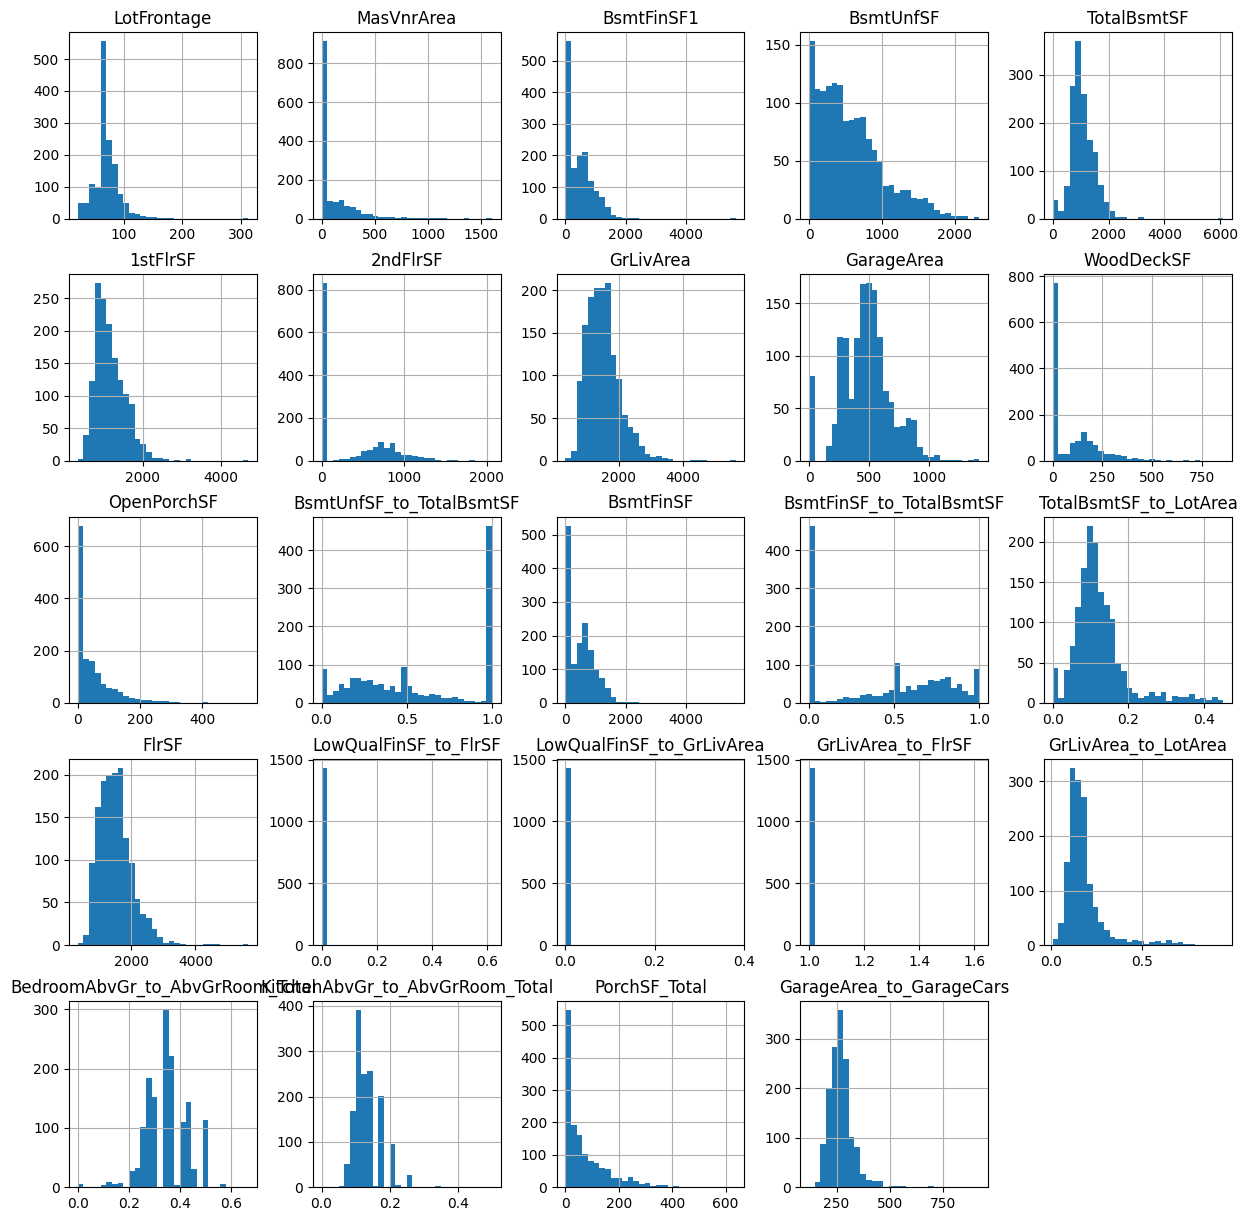

In [95]:
# check distribution before transformation
X_train[NUM_OTHERS].hist(bins=30, figsize=(15, 15))

In [96]:
# create power transformer
yeojohnson_transform = ColumnTransformer(
    transformers=[
        ('yeojohnson_transformer', PowerTransformer(method='yeo-johnson'), NUM_OTHERS),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [97]:
X_train = yeojohnson_transform.fit_transform(X_train)
X_test = yeojohnson_transform.transform(X_test)

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'GarageArea'}>,
        <Axes: title={'center': 'WoodDeckSF'}>],
       [<Axes: title={'center': 'OpenPorchSF'}>,
        <Axes: title={'center': 'BsmtUnfSF_to_TotalBsmtSF'}>,
        <Axes: title={'center': 'BsmtFinSF'}>,
        <Axes: title={'center': 'BsmtFinSF_to_TotalBsmtSF'}>,
        <Axes: title={'center': 'TotalBsmtSF_to_LotArea'}>],
       [<Axes: title={'center': 'FlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF_to_FlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF_to_GrLivArea'}>,
        <Axes: title={'center': 'GrLivArea_to_FlrSF'}>,
        <Axes: title

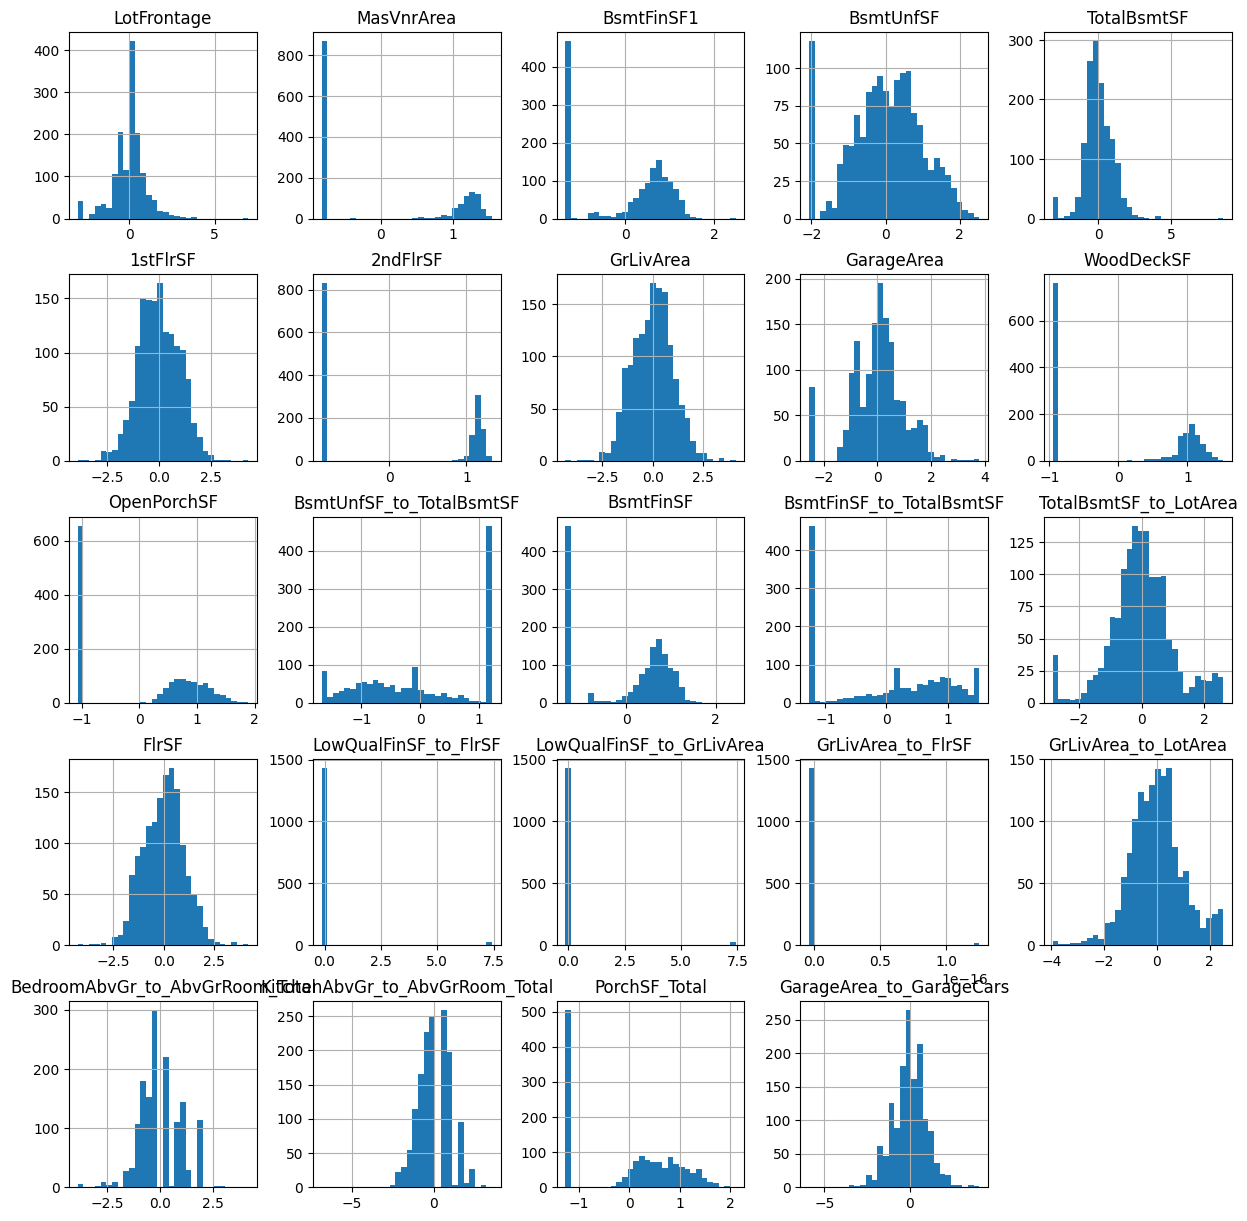

In [98]:
# check distribution after transformation
X_train[NUM_OTHERS].hist(bins=30, figsize=(15, 15))

### 4. Categorical variables

#### 4.1. Apply mappings to ordinal variables

In [99]:
class OrdinalMappingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mappings):
        self.mappings = mappings
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        for var in X_.columns:
            X_[var] = X[var].map(self.mappings)
            X_[var] = X_[var].fillna(self.mappings['Missing'])
        return X_

In [100]:
ordinal_var_map = ColumnTransformer(
    transformers=[
        ('quality_map', OrdinalMappingTransformer(QUAL_MAPPINGS), CONFIG['QUAL_VARS']),
        ('lot_shape_map', OrdinalMappingTransformer(LOT_SHAPE_MAPPINGS), ['LotShape']),
        ('utilities_map', OrdinalMappingTransformer(UTIL_MAPPINGS), ['Utilities']),
        ('slope_map', OrdinalMappingTransformer(SLOPE_MAPPINGS), ['LandSlope']),
        ('exposure_map', OrdinalMappingTransformer(EXPOSURE_MAPPINGS), ['BsmtExposure']),
        ('finish_map', OrdinalMappingTransformer(FINISH_MAPPINGS), CONFIG['FINISH_VARS']),
        ('function_map', OrdinalMappingTransformer(FUNCTION_MAPPINGS), ['Functional']),
        ('garage_map', OrdinalMappingTransformer(GARAGE_MAPPINGS), ['GarageFinish']),
        ('fence_map', OrdinalMappingTransformer(FENCE_MAPPINGS), ['Fence']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [101]:
X_train = ordinal_var_map.fit_transform(X_train)
X_test = ordinal_var_map.transform(X_test)

In [102]:
X_train[CONFIG['ORDINAL_VARS']].head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,GarageQual,GarageCond,PoolQC,BsmtFinType1,BsmtFinType2,LotShape,Utilities,LandSlope,BsmtExposure,Functional,GarageFinish,Fence
0,4,3,4,3,5,4,3,3,-1,6,1,4,4,1,1,8,2,-1
1,3,3,4,3,5,3,3,3,-1,5,1,4,4,1,4,8,2,-1
2,4,3,4,3,5,4,3,3,-1,6,1,3,4,1,2,8,2,-1
3,3,3,3,4,4,4,3,3,-1,5,1,3,4,1,1,8,1,-1
4,4,3,4,3,5,4,3,3,-1,6,1,3,4,1,3,8,2,-1


In [103]:
X_train[CONFIG['ORDINAL_VARS']].isnull().sum()

ExterQual       0
ExterCond       0
BsmtQual        0
BsmtCond        0
HeatingQC       0
KitchenQual     0
GarageQual      0
GarageCond      0
PoolQC          0
BsmtFinType1    0
BsmtFinType2    0
LotShape        0
Utilities       0
LandSlope       0
BsmtExposure    0
Functional      0
GarageFinish    0
Fence           0
dtype: int64

In [104]:
X_test[CONFIG['ORDINAL_VARS']].isnull().sum()

ExterQual       0
ExterCond       0
BsmtQual        0
BsmtCond        0
HeatingQC       0
KitchenQual     0
GarageQual      0
GarageCond      0
PoolQC          0
BsmtFinType1    0
BsmtFinType2    0
LotShape        0
Utilities       0
LandSlope       0
BsmtExposure    0
Functional      0
GarageFinish    0
Fence           0
dtype: int64

#### 4.2. Encode rare labels

In [105]:
class RareLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, rare_perc):
        self.rare_perc = rare_perc
        self.frequent_labels = {}
    def fit(self, X, y=None):
        for var in X.columns:
            tmp = X[var].value_counts(normalize=True)
            self.frequent_labels[var] = list(tmp[tmp > self.rare_perc].index)
        return self
    def transform(self, X):
        X_ = X.copy()
        for var in X_.columns:
            X_[var] = np.where(X[var].isin(self.frequent_labels[var]), X[var], 'Rare')
        return X_

In [106]:
encode_rare_label = ColumnTransformer(
    transformers=[
        ('rare_label_encoder', RareLabelEncoder(0.01), CONFIG['CAT_OTHERS']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [107]:
X_train = encode_rare_label.fit_transform(X_train)
X_test = encode_rare_label.transform(X_test)

In [108]:
X_train[CONFIG['CAT_OTHERS']].isnull().sum()

MSZoning         0
Street           0
Alley            0
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
Foundation       0
Heating          0
CentralAir       0
Electrical       0
FireplaceQu      0
GarageType       0
PavedDrive       0
MiscFeature      0
SaleType         0
SaleCondition    0
MSSubClass       0
dtype: int64

In [109]:
X_test[CONFIG['CAT_OTHERS']].isnull().sum()

MSZoning         0
Street           0
Alley            0
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
Foundation       0
Heating          0
CentralAir       0
Electrical       0
FireplaceQu      0
GarageType       0
PavedDrive       0
MiscFeature      0
SaleType         0
SaleCondition    0
MSSubClass       0
dtype: int64

#### 4.3. Encode categorical variables & optimize binning

In [110]:
# check cardinality of remaining categorical variables
X_train[CONFIG['CAT_OTHERS']].nunique().sort_values(ascending=False)

Neighborhood     23
MSSubClass       13
Exterior1st      11
Exterior2nd      11
FireplaceQu       6
Condition1        6
HouseStyle        6
LotConfig         5
SaleCondition     5
GarageType        5
Foundation        5
BldgType          5
MSZoning          5
MasVnrType        4
LandContour       4
Electrical        4
SaleType          4
Alley             3
Heating           3
RoofStyle         3
PavedDrive        3
MiscFeature       3
RoofMatl          2
Street            2
CentralAir        2
Condition2        2
dtype: int64

In [111]:
# for high cardinality variables, we will apply some grouping first before encoding them
OPT_BINNING_VARS = [col for col in CONFIG['CAT_OTHERS'] if X_train[col].nunique() > 10]

OPT_BINNING_VARS

['Neighborhood', 'Exterior1st', 'Exterior2nd', 'MSSubClass']

In [112]:
class ContinuousOptBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, dtype='categorical', monotonic_trend='ascending', transform_metric='indices'):
        self.dtype = dtype
        self.monotonic_trend = monotonic_trend
        self.transform_metric = transform_metric
        self.bin_models = {}
    def fit(self, X, y):
        for var in X.columns:
            optb_ = ContinuousOptimalBinning(name=var, dtype=self.dtype,
                                             monotonic_trend=self.monotonic_trend)
            optb_.fit(X[var], y)
            if len(optb_.splits) > 0:
                self.bin_models[var] = optb_
        return self
    def transform(self, X):
        X_ = X.copy()
        for var in X_.columns:
            if self.bin_models.get(var):
                optb_ = self.bin_models.get(var)
                X_[var] = optb_.transform(X[var], metric=self.transform_metric)
        return X_

In [113]:
# set up optimal binning transformers
optb = ColumnTransformer(
    transformers=[
        ('optbinning_transformer', ContinuousOptBinningTransformer(dtype='categorical', monotonic_trend='ascending', transform_metric='indices'), OPT_BINNING_VARS)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [114]:
X_train = optb.fit_transform(X_train, y_train)
X_test = optb.transform(X_test)

In [115]:
X_train[OPT_BINNING_VARS].head()

,Neighborhood,Exterior1st,Exterior2nd,MSSubClass
0,8,4,5,6
1,5,1,1,4
2,8,4,5,6
3,8,0,1,3
4,10,4,5,6


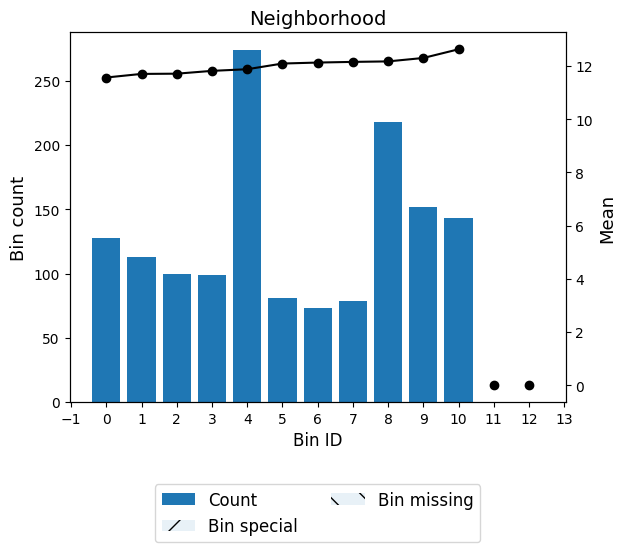

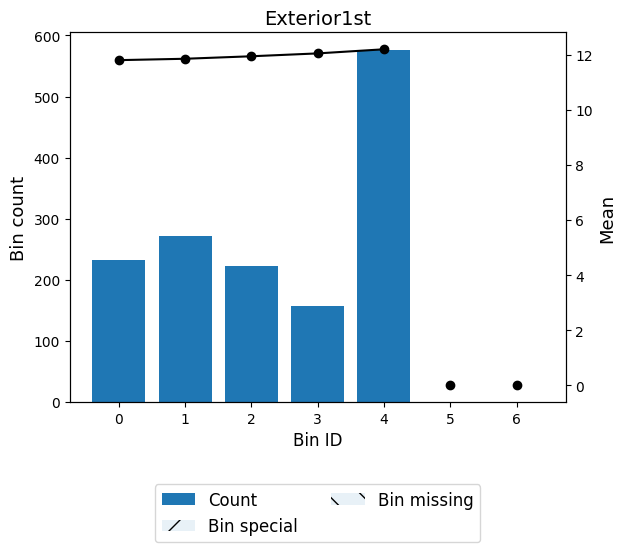

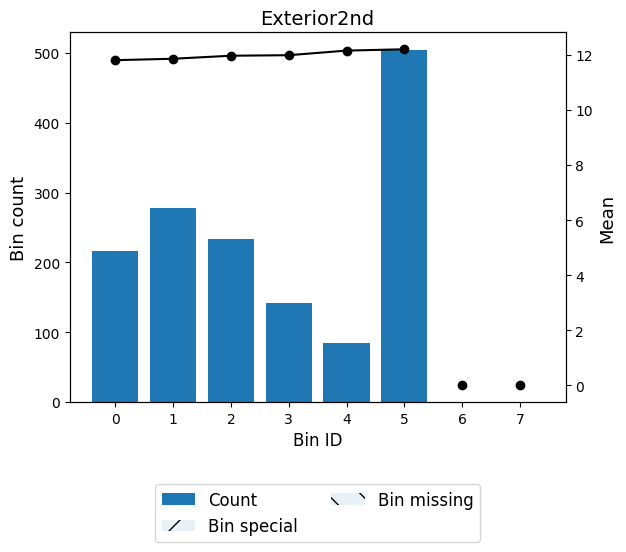

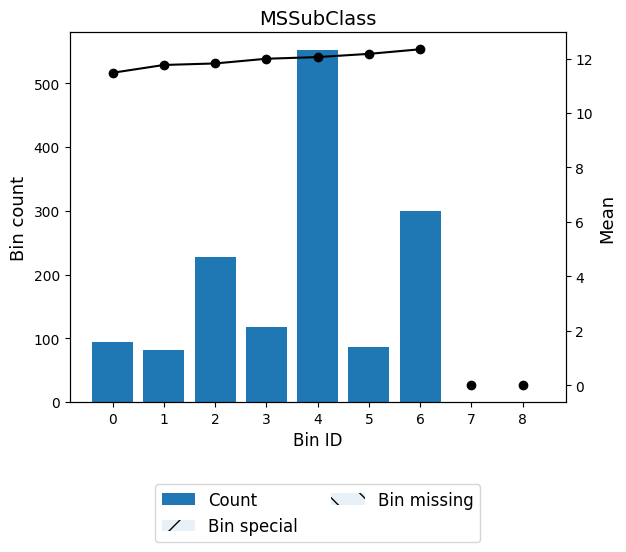

In [116]:
# plot the mean sale price vs. bins after transformation
for var in OPT_BINNING_VARS:
    t = optb.named_transformers_['optbinning_transformer'].bin_models[var].binning_table
    t.build()
    t.plot()

For the remaining categorical features, we will also encode the categories with mean target corresponding to the mean sale price to extract a monotonic relationship

In [117]:
CAT_REMAIN_VARS = [col for col in CONFIG['CAT_OTHERS'] if col not in OPT_BINNING_VARS]

CAT_REMAIN_VARS

['MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'LotConfig',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'PavedDrive',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [118]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, handle_unknown='use_encoded_value', handle_missing='use_encoded_value'):
        self.unknown_value = None
        self.missing_value = None
        self.handle_unknown = handle_unknown
        self.handle_missing = handle_missing
        if self.handle_unknown == 'use_encoded_value':
            self.unknown_value = -1
        if self.handle_missing == 'use_encoded_value':
            self.missing_value = -1

        self.ordinal_mapping = {}

    def fit(self, X, y):
        # df_ = pd.concat([X, y], axis=1)
        for var in X.columns:
            # compute mean target for each category
            sorted_cat = y.groupby(X[var]).mean().sort_values().index
            self.ordinal_mapping[var] = {cat: rank for rank, cat in enumerate(sorted_cat)}
            # mean_cat = y.groupby(X[var]).mean().to_dict()
            # self.ordinal_mapping[var] = mean_cat
            if self.missing_value:
                self.ordinal_mapping[var][np.nan] = self.missing_value
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for var in X.columns:
            X_[var] = X[var].map(self.ordinal_mapping[var])
            # Handle unknown categories
            if self.unknown_value is not None:
                X_[var] = X_[var].fillna(self.unknown_value)
            elif self.missing_value is not None:  # Handle missing values if missing_value is set
                X_[var] = X_[var].fillna(self.missing_value)
        return X_

In [119]:
categorical_encode = ColumnTransformer(
    transformers=[
        ('categorical_encoder', CategoricalEncoder(), CAT_REMAIN_VARS),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [120]:
X_train = categorical_encode.fit_transform(X_train, y_train)
X_test = categorical_encode.transform(X_test)

In [121]:
X_train[CAT_REMAIN_VARS].isnull().any()

MSZoning         False
Street           False
Alley            False
LandContour      False
LotConfig        False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
RoofStyle        False
RoofMatl         False
MasVnrType       False
Foundation       False
Heating          False
CentralAir       False
Electrical       False
FireplaceQu      False
GarageType       False
PavedDrive       False
MiscFeature      False
SaleType         False
SaleCondition    False
dtype: bool

In [122]:
X_test[CAT_REMAIN_VARS].isnull().any()

MSZoning         False
Street           False
Alley            False
LandContour      False
LotConfig        False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
RoofStyle        False
RoofMatl         False
MasVnrType       False
Foundation       False
Heating          False
CentralAir       False
Electrical       False
FireplaceQu      False
GarageType       False
PavedDrive       False
MiscFeature      False
SaleType         False
SaleCondition    False
dtype: bool

In [123]:
X_train.head()

,MSZoning,Street,Alley,LandContour,LotConfig,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,Foundation,Heating,CentralAir,Electrical,FireplaceQu,GarageType,PavedDrive,MiscFeature,SaleType,SaleCondition,Neighborhood,Exterior1st,Exterior2nd,MSSubClass,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,GarageQual,GarageCond,PoolQC,LotShape,Utilities,LandSlope,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,GarageFinish,Fence,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,BsmtUnfSF_to_TotalBsmtSF,BsmtFinSF,BsmtFinSF_to_TotalBsmtSF,TotalBsmtSF_to_LotArea,FlrSF,LowQualFinSF_to_FlrSF,LowQualFinSF_to_GrLivArea,GrLivArea_to_FlrSF,GrLivArea_to_LotArea,BedroomAbvGr_to_AbvGrRoom_Total,KitchenAbvGr_to_AbvGrRoom_Total,PorchSF_Total,GarageArea_to_GarageCars,LotArea,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TimeSince_YearBuilt,TimeSince_YearRemodAdd,TimeSince_GarageYrBlt,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,MoSold,BsmtBath_Total,AbvGrBath_Total,AbvGrRoom_Total,QuSold
0,3,1,2,1,0,2,1,3,5,0,0,2,4,2,1,3,1,3,2,2,2,3,8,4,5,6,4,3,4,3,5,4,3,3,-1,4,4,1,1,6,1,8,2,-1,-0.146062,1.230708,0.797537,-0.887576,-0.404029,-0.799624,1.170239,0.528531,0.383899,-0.950337,0.841820,-1.057914,0.722305,1.045206,-0.182550,0.536472,-0.134652,-0.134652,-3.469447e-18,0.610555,-0.880315,-1.193144,0.472863,0.240068,1,0,0,0,0,0,0,0,0.949275,0.883333,0.936364,0.50,0.036765,0.098361,0.046729,7,5,1.0,0.0,2,1,3,1,8,0,2.0,2,1.0,3,11,1
1,3,1,2,1,2,1,1,3,3,0,0,1,2,2,1,3,3,3,2,2,2,3,5,1,1,4,3,3,4,3,5,3,3,3,-1,4,4,1,4,5,1,8,2,-1,0.546852,-0.818452,1.011471,-0.434388,0.508177,0.429151,-0.871454,-0.382755,-0.004602,1.213714,-1.071307,-0.893494,0.938622,0.909162,0.328339,-0.374715,-0.134652,-0.134652,-3.469447e-18,-0.408547,0.353702,-0.014653,-1.266998,-0.725430,1,0,0,0,0,0,0,0,0.753623,0.433333,0.690909,0.25,0.227941,0.524590,0.289720,6,8,0.0,1.0,2,0,3,1,6,1,2.0,5,1.0,2,8,2
2,3,1,2,1,0,2,1,3,5,0,0,2,4,2,1,3,3,3,2,2,2,3,8,4,5,6,4,3,4,3,5,4,3,3,-1,3,4,1,2,6,1,8,2,-1,-0.000631,1.193873,0.571325,-0.048083,-0.253787,-0.568533,1.172896,0.659112,0.641990,-0.950337,0.668453,-0.140195,0.494808,0.229373,-0.568408,0.667609,-0.134652,-0.134652,-3.469447e-18,0.042089,-0.155393,-0.453115,0.267734,0.748030,1,0,0,0,0,0,0,0,0.934783,0.866667,0.918182,0.50,0.051471,0.114754,0.065421,7,5,1.0,0.0,2,1,3,1,6,1,2.0,9,1.0,3,9,3
3,3,1,2,1,1,2,1,3,5,0,0,1,1,2,1,3,4,1,2,2,2,0,8,0,1,3,3,3,3,4,4,4,3,3,-1,3,4,1,1,5,1,8,1,-1,-0.397299,-0.818452,0.142272,0.183337,-0.644806,-0.429428,1.146834,0.540797,0.786092,-0.950337,0.584540,0.520422,0.067188,-0.449891,-0.623819,0.548784,-0.134652,-0.134652,-3.469447e-18,0.336796,0.353702,-0.014653,1.528772,-1.167336,1,0,0,1,0,0,0,0,0.311594,0.333333,0.890909,0.00,0.669118,0.606557,0.074766,7,5,1.0,0.0,1,0,3,1,7,1,3.0,2,1.0,1,8,1
4,3,1,2,1,2,2,1,3,5,0,0,2,4,2,1,3,3,3,2,2,2,3,10,4,5,6,4,3,4,3,5,4,3,3,-1,3,4,1,3,6,1,8,2,-1,0.718695,1.333038,0.750541,0.077485,0.254387,0.124698,1.209630,1.282894,1.583257,1.079695,0.991895,-0.267252,0.674935,0.350804,-0.599719,1.296025,-0.134652,-0.134652,-3.469447e-18,-0.028381,-0.155393,-1.506357,0.659712,0.325757,1,0,0,0,0,0,0,0,0.927536,0.833333,0.909091,0.50,0.058824,0.147541,0.074766,8,5,1.0,0.0,2,1,4,1,9,1,3.0,12,1.0,3,12,4


### 5. Feature engineering pipeline

In [124]:
# create the pipeline
feature_pipeline = Pipeline(
    steps=[
        ('impute_missing_str', impute_missing_str),     # impute missing values with string 'missing' 
        ('impute_frequent_cat', impute_frequent_cat),   # impute missing values with frequent category
        ('impute_median', impute_median),               # impute missing values with median
        ('create_temporal_vars', create_temporal_variables),    # create temporal variables
        ('scale_temporal_vars', scaler),                        # scale temporal vars
        ('binarize_skewed_vars', binarize_skewed_vars),     # binarize skewed variables
        ('yeojohnson_transform_vars', yeojohnson_transform),    # apply yeojohnson transformation on numerical variables
        ('map_ordinal_vars', ordinal_var_map),                  # apply mappings to ordinal variables
        ('encode_rare_labels', encode_rare_label),  # encode rare labels
        ('optimal_binning', optb),                  # apply optbinning and encoding
        ('encode_cat_vars', categorical_encode),    # encode categorical variables for monotonic relationship,
    ],
)

In [125]:
feature_pipeline

Pipeline(steps=[('impute_missing_str',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('missing_str_imputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature'])],
                                   verbose_feature_names_out=False)),
                ('impute_frequent_cat',
                 ColumnTransformer(remainder='passthrough',
                                   transfor...
                                   transformers=[('categorical_encoder',
                                                  CategoricalEncoder(),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LandContour',
                                                   'LotConfig', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'MasVnrType',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'FireplaceQu', 'GarageType',
                                                   'PavedDrive', 'MiscFeature',
                                                   'SaleType',
                                                   'SaleCondition'])],
                                   verbose_feature_names_out=False))])

In [126]:
# test the pipeline
feature_pipeline = clone(feature_pipeline)

In [127]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df = pd.concat([df_train, df_test], axis=0)

# create new variables
df = create_new_variables(df)

# separate target variable
target = 'SalePrice'
# separate into train and test set
X_train = df[~df[target].isnull()].drop(target, axis=1)
y_train = df[~df[target].isnull()][target]
X_test = df[df[target].isnull()].drop(target, axis=1)
y_test = df[df[target].isnull()][target]

# drop column id
X_train.drop('Id', axis=1, inplace=True)
X_test.drop('Id', axis=1, inplace=True)

# apply log transform to target
y_train = y_train.apply(np.log)
y_test = y_test.apply(np.log)

In [128]:
# cast all variables in CAT_VARS as object
X_train[CONFIG['CAT_VARS']] = X_train[CONFIG['CAT_VARS']].astype('O')
X_test[CONFIG['CAT_VARS']] = X_test[CONFIG['CAT_VARS']].astype('O')

In [129]:
X_train = feature_pipeline.fit_transform(X_train, y_train)
X_test = feature_pipeline.transform(X_test)

In [130]:
X_train.head()

,MSZoning,Street,Alley,LandContour,LotConfig,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,Foundation,Heating,CentralAir,Electrical,FireplaceQu,GarageType,PavedDrive,MiscFeature,SaleType,SaleCondition,Neighborhood,Exterior1st,Exterior2nd,MSSubClass,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,GarageQual,GarageCond,PoolQC,LotShape,Utilities,LandSlope,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,GarageFinish,Fence,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,BsmtUnfSF_to_TotalBsmtSF,BsmtFinSF,BsmtFinSF_to_TotalBsmtSF,TotalBsmtSF_to_LotArea,FlrSF,LowQualFinSF_to_FlrSF,LowQualFinSF_to_GrLivArea,GrLivArea_to_FlrSF,GrLivArea_to_LotArea,BedroomAbvGr_to_AbvGrRoom_Total,KitchenAbvGr_to_AbvGrRoom_Total,PorchSF_Total,GarageArea_to_GarageCars,LotArea,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TimeSince_YearBuilt,TimeSince_YearRemodAdd,TimeSince_GarageYrBlt,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,MoSold,BsmtBath_Total,AbvGrBath_Total,AbvGrRoom_Total,QuSold
0,3,1,2,1,0,2,1,3,5,0,0,2,4,2,1,3,1,3,2,2,2,3,8,4,5,6,4,3,4,3,5,4,3,3,-1,4,4,1,1,6,1,8,2,-1,-0.146062,1.230708,0.797537,-0.887576,-0.404029,-0.799624,1.170239,0.528531,0.383899,-0.950337,0.841820,-1.057914,0.722305,1.045206,-0.182550,0.536472,-0.134652,-0.134652,-3.469447e-18,0.610555,-0.880315,-1.193144,0.472863,0.240068,1,0,0,0,0,0,0,0,0.949275,0.883333,0.936364,0.50,0.036765,0.098361,0.046729,7,5,1.0,0.0,2,1,3,1,8,0,2.0,2,1.0,3,11,1
1,3,1,2,1,2,1,1,3,3,0,0,1,2,2,1,3,3,3,2,2,2,3,5,1,1,4,3,3,4,3,5,3,3,3,-1,4,4,1,4,5,1,8,2,-1,0.546852,-0.818452,1.011471,-0.434388,0.508177,0.429151,-0.871454,-0.382755,-0.004602,1.213714,-1.071307,-0.893494,0.938622,0.909162,0.328339,-0.374715,-0.134652,-0.134652,-3.469447e-18,-0.408547,0.353702,-0.014653,-1.266998,-0.725430,1,0,0,0,0,0,0,0,0.753623,0.433333,0.690909,0.25,0.227941,0.524590,0.289720,6,8,0.0,1.0,2,0,3,1,6,1,2.0,5,1.0,2,8,2
2,3,1,2,1,0,2,1,3,5,0,0,2,4,2,1,3,3,3,2,2,2,3,8,4,5,6,4,3,4,3,5,4,3,3,-1,3,4,1,2,6,1,8,2,-1,-0.000631,1.193873,0.571325,-0.048083,-0.253787,-0.568533,1.172896,0.659112,0.641990,-0.950337,0.668453,-0.140195,0.494808,0.229373,-0.568408,0.667609,-0.134652,-0.134652,-3.469447e-18,0.042089,-0.155393,-0.453115,0.267734,0.748030,1,0,0,0,0,0,0,0,0.934783,0.866667,0.918182,0.50,0.051471,0.114754,0.065421,7,5,1.0,0.0,2,1,3,1,6,1,2.0,9,1.0,3,9,3
3,3,1,2,1,1,2,1,3,5,0,0,1,1,2,1,3,4,1,2,2,2,0,8,0,1,3,3,3,3,4,4,4,3,3,-1,3,4,1,1,5,1,8,1,-1,-0.397299,-0.818452,0.142272,0.183337,-0.644806,-0.429428,1.146834,0.540797,0.786092,-0.950337,0.584540,0.520422,0.067188,-0.449891,-0.623819,0.548784,-0.134652,-0.134652,-3.469447e-18,0.336796,0.353702,-0.014653,1.528772,-1.167336,1,0,0,1,0,0,0,0,0.311594,0.333333,0.890909,0.00,0.669118,0.606557,0.074766,7,5,1.0,0.0,1,0,3,1,7,1,3.0,2,1.0,1,8,1
4,3,1,2,1,2,2,1,3,5,0,0,2,4,2,1,3,3,3,2,2,2,3,10,4,5,6,4,3,4,3,5,4,3,3,-1,3,4,1,3,6,1,8,2,-1,0.718695,1.333038,0.750541,0.077485,0.254387,0.124698,1.209630,1.282894,1.583257,1.079695,0.991895,-0.267252,0.674935,0.350804,-0.599719,1.296025,-0.134652,-0.134652,-3.469447e-18,-0.028381,-0.155393,-1.506357,0.659712,0.325757,1,0,0,0,0,0,0,0,0.927536,0.833333,0.909091,0.50,0.058824,0.147541,0.074766,8,5,1.0,0.0,2,1,4,1,9,1,3.0,12,1.0,3,12,4


In [131]:
X_train.dtypes

MSZoning                             int64
Street                               int64
Alley                                int64
LandContour                          int64
LotConfig                            int64
Condition1                           int64
Condition2                           int64
BldgType                             int64
HouseStyle                           int64
RoofStyle                            int64
RoofMatl                             int64
MasVnrType                           int64
Foundation                           int64
Heating                              int64
CentralAir                           int64
Electrical                           int64
FireplaceQu                          int64
GarageType                           int64
PavedDrive                           int64
MiscFeature                          int64
SaleType                             int64
SaleCondition                        int64
Neighborhood                         int32
Exterior1st

In [132]:
X_test.isnull().sum()

MSZoning                           0
Street                             0
Alley                              0
LandContour                        0
LotConfig                          0
Condition1                         0
Condition2                         0
BldgType                           0
HouseStyle                         0
RoofStyle                          0
RoofMatl                           0
MasVnrType                         0
Foundation                         0
Heating                            0
CentralAir                         0
Electrical                         0
FireplaceQu                        0
GarageType                         0
PavedDrive                         0
MiscFeature                        0
SaleType                           0
SaleCondition                      0
Neighborhood                       0
Exterior1st                        0
Exterior2nd                        0
MSSubClass                         0
ExterQual                          0
E

In [133]:
X_train.shape, X_test.shape

((1460, 99), (1459, 99))

In [134]:
# save the pipeline
output_dir = 'feature_engineering'
os.makedirs(output_dir, exist_ok=True)

with open(f"{output_dir}/feature_pipeline.pkl", 'wb') as file:
    pickle.dump(feature_pipeline, file)

In [135]:
# save the train and test set
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

X_train.to_csv(f'{output_dir}/X_train.csv', index=False)
X_test.to_csv(f'{output_dir}/X_test.csv', index=False)
y_train.to_csv(f'{output_dir}/y_train.csv', index=False)
y_test.to_csv(f'{output_dir}/y_test.csv', index=False)

## Feature selection

In [136]:
X_train = pd.read_csv('./processed_data/X_train.csv')
y_train = pd.read_csv('./processed_data/y_train.csv')

In [137]:
X_train.shape, X_test.shape

((1460, 99), (1459, 99))

In [138]:
# select a subset of the most important features using Lasso
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=RANDOM_SEED))

sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=42))

In [139]:
# check the number of features selected
sel_.get_support().sum()

61

In [140]:
sel_.get_support()

array([ True, False, False,  True,  True,  True, False,  True,  True,
        True, False, False,  True, False,  True, False,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
        True, False,  True,  True,  True, False,  True, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True,  True,  True, False,  True, False, False])

In [141]:
# get the list of selected features
selected_feat = X_train.columns[(sel_.get_support())]
selected_feat

Index(['MSZoning', 'LandContour', 'LotConfig', 'Condition1', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Foundation', 'CentralAir', 'FireplaceQu',
       'PavedDrive', 'SaleType', 'SaleCondition', 'Neighborhood',
       'Exterior1st', 'Exterior2nd', 'MSSubClass', 'ExterQual', 'BsmtQual',
       'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'PoolQC',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional',
       'GarageFinish', 'Fence', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF',
       'BsmtUnfSF_to_TotalBsmtSF', 'BsmtFinSF', 'TotalBsmtSF_to_LotArea',
       'FlrSF', 'LowQualFinSF_to_FlrSF', 'LowQualFinSF_to_GrLivArea',
       'GrLivArea_to_LotArea', 'KitchenAbvGr_to_AbvGrRoom_Total',
       'PorchSF_Total', 'GarageArea_to_GarageCars', 'BsmtFinSF2',
       'ScreenPorch', 'YrSold', 'TimeSince_YearRemodAdd', 'OverallQual',
       'OverallCond', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr', 'Fi

In [142]:
# save the feature selector
output_dir = 'feature_selection'
os.makedirs(output_dir, exist_ok=True)

with open(f'{output_dir}/feature_selection_lasso.pkl', 'wb') as file:
    pickle.dump(sel_, file)

## Modeling

In [5]:
MODEL_OUTPUT_DIR = 'model_output'
MODEL_PARAM_DIR = 'model_best_params'

os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_PARAM_DIR, exist_ok=True)

### 1. Apply feature selection

In [6]:
X = pd.read_csv('./processed_data/X_train.csv')
y = pd.read_csv('./processed_data/y_train.csv')

In [7]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

In [8]:
X_train.shape, X_test.shape

((1168, 99), (292, 99))

In [9]:
with open('./feature_selection/feature_selection_lasso.pkl', 'rb') as file:
    feature_selector = pickle.load(file)

In [10]:
feature_selector.get_support().sum()

61

In [11]:
X_train = feature_selector.transform(X_train)
X_test = feature_selector.transform(X_test)

In [12]:
X_train.shape, X_test.shape

((1168, 61), (292, 61))

In [13]:
X_train.head()

,MSZoning,LandContour,LotConfig,Condition1,BldgType,HouseStyle,RoofStyle,Foundation,CentralAir,FireplaceQu,PavedDrive,SaleType,SaleCondition,Neighborhood,Exterior1st,Exterior2nd,MSSubClass,ExterQual,BsmtQual,HeatingQC,KitchenQual,GarageQual,GarageCond,PoolQC,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,GarageFinish,Fence,LotFrontage,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,WoodDeckSF,BsmtUnfSF_to_TotalBsmtSF,BsmtFinSF,TotalBsmtSF_to_LotArea,FlrSF,LowQualFinSF_to_FlrSF,LowQualFinSF_to_GrLivArea,GrLivArea_to_LotArea,KitchenAbvGr_to_AbvGrRoom_Total,PorchSF_Total,GarageArea_to_GarageCars,BsmtFinSF2,ScreenPorch,YrSold,TimeSince_YearRemodAdd,OverallQual,OverallCond,BsmtFullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,MoSold,AbvGrBath_Total
254,3,1,0,2,3,3,0,2,1,1,2,2,3,4,1,1,4,3,3,3,3,3,3,-1,1,3,1,8,2,-1,0.094280,-0.818452,0.971568,0.618986,0.554819,-0.871454,-0.261733,1.160693,-0.659665,0.898192,0.685737,-0.254106,-0.134652,-0.134652,0.006856,1.029057,-1.266998,0.589436,0,0,1.00,0.885246,5,6,1.0,0,3,0,1.0,6,1
1066,3,1,0,2,3,5,0,4,1,3,2,2,3,7,4,5,6,4,4,4,3,3,3,-1,1,1,1,8,2,-1,-0.448976,-0.818452,-1.353159,-0.540316,-1.021706,1.150881,0.274043,-0.950337,1.221248,-1.365362,-0.170492,0.281313,-0.134652,-0.134652,0.588959,-0.843906,0.241914,-1.958887,0,0,0.75,0.262295,6,7,0.0,1,3,1,2.0,5,3
638,3,1,0,1,3,3,0,2,1,1,1,2,3,2,1,0,0,3,2,4,3,3,3,-1,1,1,1,8,1,3,-0.048690,-0.818452,-1.353159,-0.547558,-1.033865,-0.871454,-1.761796,1.242378,1.221248,-1.365362,-0.386334,-1.740443,-0.134652,-0.134652,-1.262607,1.640014,1.084921,0.046981,0,0,0.50,0.967213,5,7,0.0,0,2,0,0.0,5,1
799,3,1,1,1,3,1,0,1,1,3,2,2,3,3,0,0,2,3,4,5,4,3,3,-1,1,5,1,8,1,3,-0.397299,1.276811,0.664479,-0.706265,-0.363877,1.154590,0.628691,-0.950337,-0.904655,0.588331,-0.178355,0.637046,-0.134652,-0.134652,1.034850,-0.453115,1.417721,-0.477152,0,0,0.25,0.950820,5,7,1.0,1,3,2,1.0,6,2
380,3,1,0,2,3,1,0,1,1,4,2,2,3,3,3,0,2,3,3,3,4,3,3,-1,1,2,1,8,1,-1,-0.938614,-0.818452,0.146710,-0.010774,-0.221512,1.121815,0.494985,-0.950337,0.707243,0.071583,1.248337,0.502806,-0.134652,-0.134652,1.638106,-0.014653,1.354928,0.808781,0,0,1.00,1.000000,5,6,0.0,0,3,1,1.0,5,2


In [14]:
X_train.dtypes

MSZoning                             int64
LandContour                          int64
LotConfig                            int64
Condition1                           int64
BldgType                             int64
HouseStyle                           int64
RoofStyle                            int64
Foundation                           int64
CentralAir                           int64
FireplaceQu                          int64
PavedDrive                           int64
SaleType                             int64
SaleCondition                        int64
Neighborhood                         int64
Exterior1st                          int64
Exterior2nd                          int64
MSSubClass                           int64
ExterQual                            int64
BsmtQual                             int64
HeatingQC                            int64
KitchenQual                          int64
GarageQual                           int64
GarageCond                           int64
PoolQC     

### 2. Linear regression

#### 2.1. Lasso

In [153]:
lasso = Lasso(alpha=0.001, random_state=RANDOM_SEED, max_iter=100000, selection='random')

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# set up gridsearch cv
model = GridSearchCV(
    estimator=lasso,
    param_grid={
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    },
    cv=kf,
    scoring='neg_root_mean_squared_error',
    refit=True,
)

In [154]:
model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(alpha=0.001, max_iter=100000, random_state=42,
                             selection='random'),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_root_mean_squared_error')

In [155]:
model.best_params_

{'alpha': 0.001}

In [156]:
model.best_score_

-0.12842287707041136

In [157]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

train rmse: 27719
train r2: 0.871172501993295
train adjusted r2: 0.8640671879079342

test rmse: 28941
test r2: 0.8907979382687642
test adjusted r2: 0.8618356523313495



Text(0.5, 1.0, 'Evaluation of Lasso Prediction')

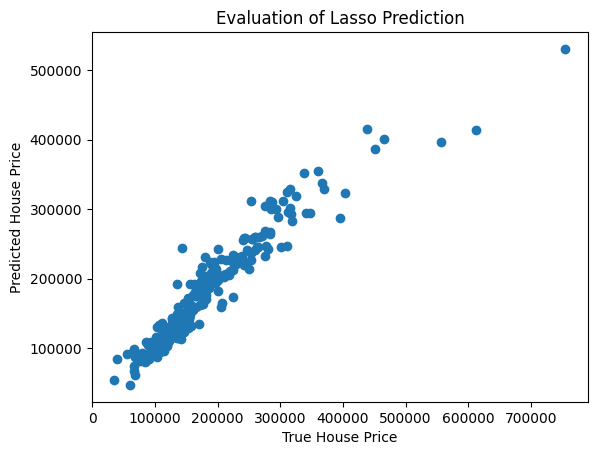

In [158]:
plt.scatter(np.exp(y_test), np.exp(test_pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Prediction')

Text(0.5, 1.0, 'Feature Importance')

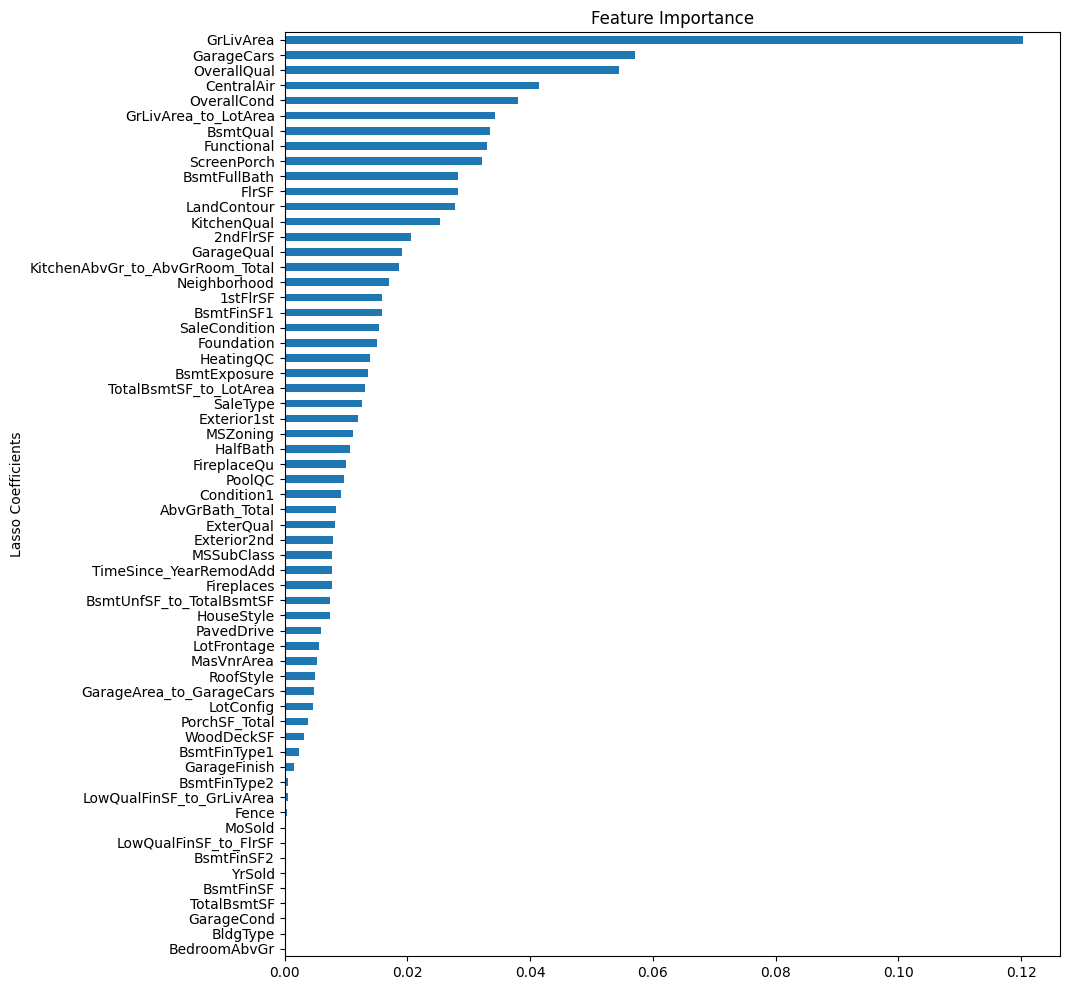

In [159]:
# check feature importance
importance = pd.Series(np.abs(model.best_estimator_.coef_.ravel()))
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=True)
importance.plot.barh(figsize=(10, 12))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

In [160]:
# save this model
with open(f'./{MODEL_OUTPUT_DIR}/lasso.pkl', 'wb') as file:
    pickle.dump(model, file)

#### 2.2. Ridge

In [161]:
ridge = Ridge(alpha=0.001, random_state=RANDOM_SEED, max_iter=100000, solver='saga')

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# set up gridsearch cv
model = GridSearchCV(
    estimator=ridge,
    param_grid={
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'solver': ['saga', 'svd', 'sag', 'lsqr'],
    },
    cv=kf,
    scoring='neg_root_mean_squared_error',
    refit=True,
)

In [162]:
model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Ridge(alpha=0.001, max_iter=100000, random_state=42,
                             solver='saga'),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'solver': ['saga', 'svd', 'sag', 'lsqr']},
             scoring='neg_root_mean_squared_error')

In [163]:
model.best_params_

{'alpha': 1, 'solver': 'lsqr'}

In [164]:
model.best_score_

-0.12969962697307466

In [165]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

train rmse: 27094
train r2: 0.8769183862188256
train adjusted r2: 0.870129978948797

test rmse: 29735
test r2: 0.8847259750349495
test adjusted r2: 0.8541532988485666



Text(0.5, 1.0, 'Evaluation of Ridge Prediction')

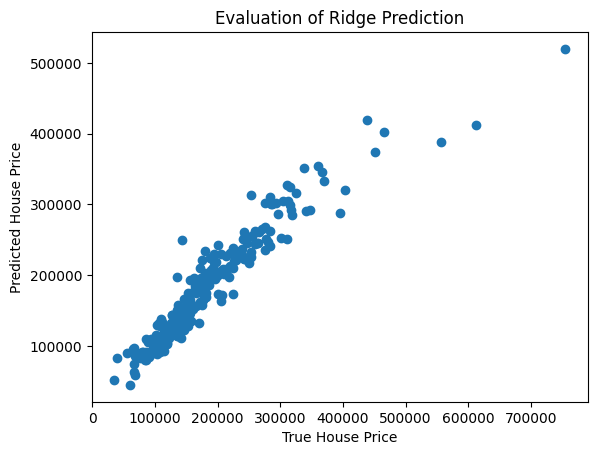

In [166]:
plt.scatter(np.exp(y_test), np.exp(test_pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Ridge Prediction')

Text(0.5, 1.0, 'Feature Importance')

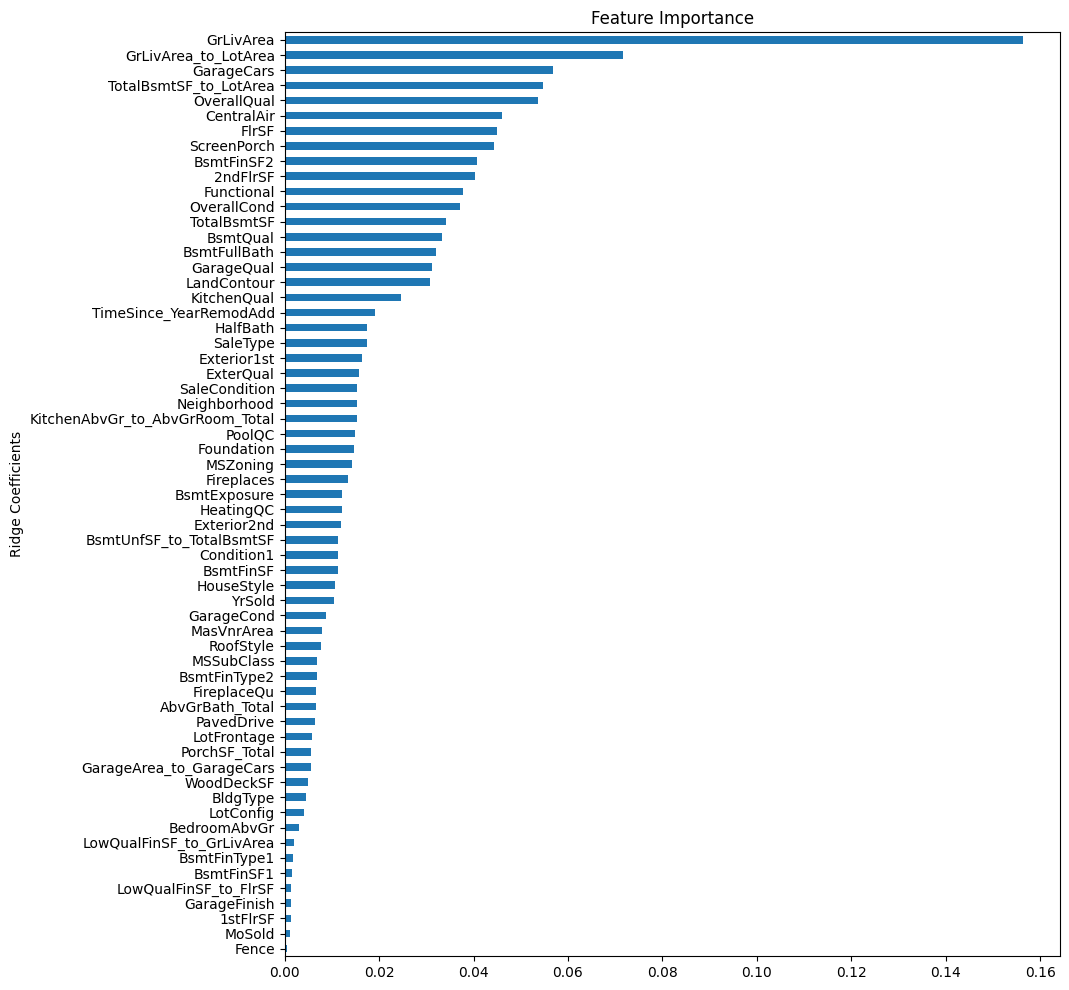

In [167]:
# check feature importance
importance = pd.Series(np.abs(model.best_estimator_.coef_.ravel()))
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=True)
importance.plot.barh(figsize=(10, 12))
plt.ylabel('Ridge Coefficients')
plt.title('Feature Importance')

In [168]:
# save this model
with open(f'./{MODEL_OUTPUT_DIR}/ridge.pkl', 'wb') as file:
    pickle.dump(model, file)

#### 2.3. ElasticNet

In [169]:
eln = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=RANDOM_SEED, max_iter=100000)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# set up gridsearch cv
model = GridSearchCV(
    estimator=eln,
    param_grid={
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.1, 0.2, 0.5, 0.8, 0.9],
        # 'solver': ['saga', 'svd', 'sag', 'lsqr'],
    },
    cv=kf,
    scoring='neg_root_mean_squared_error',
    refit=True,
)

In [170]:
model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=ElasticNet(alpha=0.001, max_iter=100000,
                                  random_state=42),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'l1_ratio': [0.1, 0.2, 0.5, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error')

In [171]:
model.best_params_

{'alpha': 0.01, 'l1_ratio': 0.1}

In [172]:
model.best_score_

-0.12818145536070635

In [173]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

train rmse: 27917
train r2: 0.8693270483262198
train adjusted r2: 0.8621199506299263

test rmse: 28763
test r2: 0.8921359002023779
test adjusted r2: 0.8635284650386608



Text(0.5, 1.0, 'Evaluation of ElasticNet Prediction')

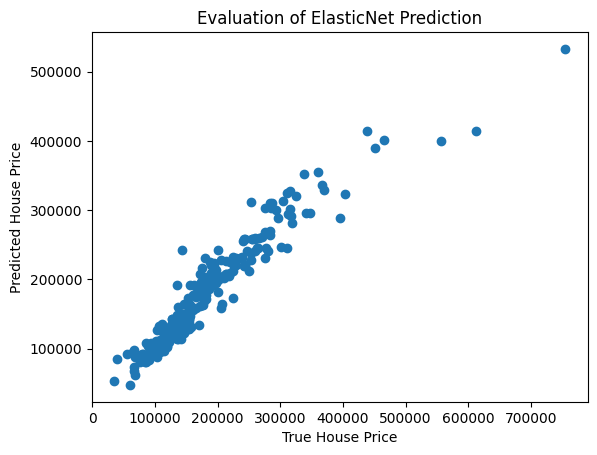

In [174]:
plt.scatter(np.exp(y_test), np.exp(test_pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of ElasticNet Prediction')

Text(0.5, 1.0, 'Feature Importance')

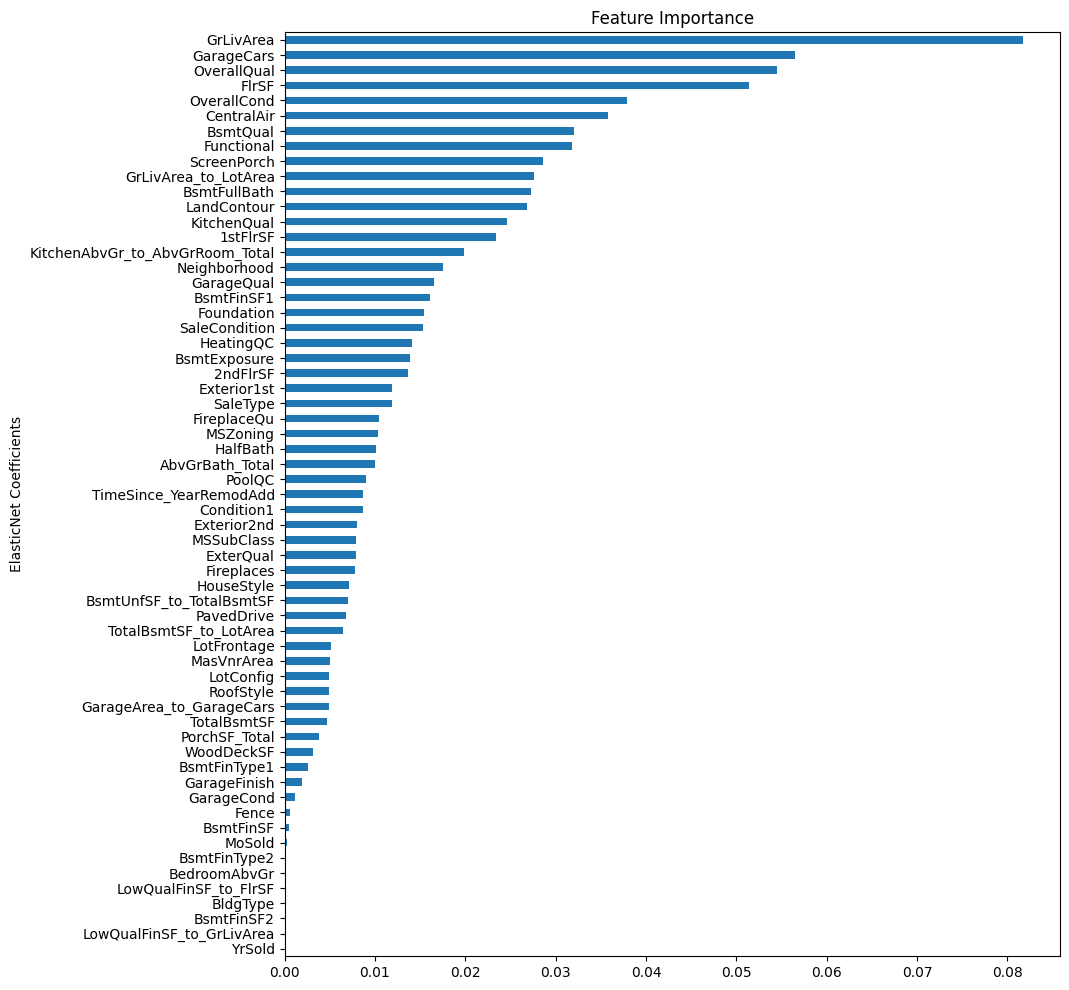

In [175]:
# check feature importance
importance = pd.Series(np.abs(model.best_estimator_.coef_.ravel()))
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=True)
importance.plot.barh(figsize=(10, 12))
plt.ylabel('ElasticNet Coefficients')
plt.title('Feature Importance')

In [176]:
# save this model
with open(f'./{MODEL_OUTPUT_DIR}/elastic_net.pkl', 'wb') as file:
    pickle.dump(model, file)

### 3. RandomForestRegressor

In [177]:
def objective(trial):
    param_grid_ = {
        'n_jobs': -1,
        'random_state': RANDOM_SEED,
        'n_estimators': trial.suggest_int('n_estimators', 2000, 6000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_samples_split': trial.suggest_int('min_samples_split', 8, 20, 2),
        'max_features': trial.suggest_loguniform('max_features', 0.1, 1.0),
        'max_samples': trial.suggest_loguniform('max_samples', 0.3, 1.0),
    }

    # create a model with the params
    model = RandomForestRegressor(**param_grid_)

    # KFold cross validations
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    rmse = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # fit the model
        model.fit(X_fold_train, y_fold_train)
        # predict
        y_pred = model.predict(X_fold_val)
        # calculate rmse
        fold_rmse = root_mean_squared_error(np.exp(y_fold_val), np.exp(y_pred))
        rmse.append(fold_rmse)
    return np.mean(rmse)

In [178]:
# create a study
study = optuna.create_study(
    study_name='rf_study',
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

try:
    study.optimize(objective, n_trials=10)
except:
    raise

[I 2025-02-17 20:49:34,925] A new study created in memory with name: rf_study
[I 2025-02-17 20:49:44,825] Trial 0 finished with value: 34120.30160941109 and parameters: {'n_estimators': 2200, 'max_depth': 4, 'min_samples_split': 16, 'max_features': 0.8139581919560288, 'max_samples': 0.5146208651612333}. Best is trial 0 with value: 34120.30160941109.
[I 2025-02-17 20:50:05,324] Trial 1 finished with value: 34048.90162204693 and parameters: {'n_estimators': 4800, 'max_depth': 4, 'min_samples_split': 20, 'max_features': 0.6905426192343167, 'max_samples': 0.6485437876749081}. Best is trial 1 with value: 34048.90162204693.
[I 2025-02-17 20:50:29,516] Trial 2 finished with value: 33963.435200108965 and parameters: {'n_estimators': 5600, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 0.12018919377052174, 'max_samples': 0.5252042664972817}. Best is trial 2 with value: 33963.435200108965.
[I 2025-02-17 20:51:00,451] Trial 3 finished with value: 31045.60808159543 and parameters: {'n_est

In [179]:
study.best_params

{'n_estimators': 5500,
 'max_depth': 6,
 'min_samples_split': 14,
 'max_features': 0.3085295077237686,
 'max_samples': 0.5089321343044807}

In [180]:
study.best_value

31045.60808159543

In [183]:
# save best params to json file
with open(f'./{MODEL_PARAM_DIR}/rf_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)

In [185]:
with open(f'./{MODEL_PARAM_DIR}/rf_params.json', 'r') as file:
    param_grid_ = json.load(file)

In [186]:
# train the model with best params
model = RandomForestRegressor(
    n_jobs=-1,
    random_state=RANDOM_SEED,
    **param_grid_
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=0.3085295077237686,
                      max_samples=0.5089321343044807, min_samples_split=14,
                      n_estimators=5500, n_jobs=-1, random_state=42)

In [187]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

train rmse: 25127
train r2: 0.8941415155618332
train adjusted r2: 0.8883030277221151

test rmse: 33208
test r2: 0.8562235679170933
test adjusted r2: 0.8180915576690181



The RandomForestRegressor did not perform so well on the test set compared to the baseline regression models.

Text(0.5, 1.0, 'Evaluation of RandomForestRegressor Prediction')

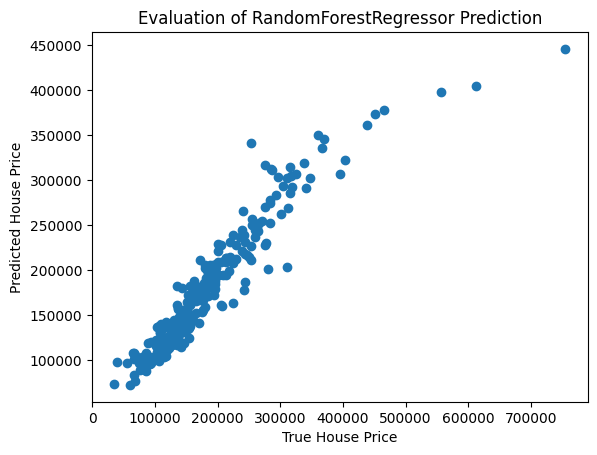

In [188]:
plt.scatter(np.exp(y_test), np.exp(test_pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of RandomForestRegressor Prediction')

In [189]:
with open(f'./{MODEL_OUTPUT_DIR}/rf_regressor.pkl', 'wb') as file:
    pickle.dump(model, file)

### 4. HistGradientBoostingRegressor

In [190]:
def objective(trial):
    param_grid_ = {
        'loss': 'squared_error',
        'random_state': RANDOM_SEED,
        'max_iter': trial.suggest_int('max_iter', 3000, 5000, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.009, 0.01, 0.02]),
        'max_features': trial.suggest_loguniform('max_features', 0.1, 1.0),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 0.1, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 20),
    }

    # create a model with the params
    model = HistGradientBoostingRegressor(**param_grid_)

    # KFold cross validations
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    rmse = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # fit the model
        model.fit(X_fold_train, y_fold_train)
        # predict
        y_pred = model.predict(X_fold_val)
        # calculate rmse
        fold_rmse = root_mean_squared_error(np.exp(y_fold_val), np.exp(y_pred))
        rmse.append(fold_rmse)
    return np.mean(rmse)

In [191]:
# create a study
study = optuna.create_study(
    study_name='histgbm_study',
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

try:
    study.optimize(objective, n_trials=10)
except:
    raise

[I 2025-02-17 20:54:50,342] A new study created in memory with name: histgbm_study
[I 2025-02-17 20:55:09,576] Trial 0 finished with value: 25794.693694634418 and parameters: {'max_iter': 3950, 'max_depth': 5, 'learning_rate': 0.02, 'max_features': 0.13252827778524148, 'l2_regularization': 1.9322429880072678, 'min_samples_leaf': 20}. Best is trial 0 with value: 25794.693694634418.
[I 2025-02-17 20:55:24,659] Trial 1 finished with value: 26186.047811712393 and parameters: {'max_iter': 4550, 'max_depth': 3, 'learning_rate': 0.008, 'max_features': 0.9227135532114795, 'l2_regularization': 7.12081498318726, 'min_samples_leaf': 20}. Best is trial 0 with value: 25794.693694634418.
[I 2025-02-17 20:55:59,082] Trial 2 finished with value: 25776.31901875981 and parameters: {'max_iter': 4700, 'max_depth': 5, 'learning_rate': 0.008, 'max_features': 0.35635908282310413, 'l2_regularization': 1.5582760063997256, 'min_samples_leaf': 8}. Best is trial 2 with value: 25776.31901875981.
[I 2025-02-17 20:5

In [192]:
study.best_params

{'max_iter': 4400,
 'max_depth': 4,
 'learning_rate': 0.008,
 'max_features': 0.1656084947768921,
 'l2_regularization': 1.9389186289412705,
 'min_samples_leaf': 15}

In [193]:
study.best_value

25332.08717721607

In [194]:
# save best params to json file
with open(f'./{MODEL_PARAM_DIR}/histgbm_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)

In [195]:
with open(f'./{MODEL_PARAM_DIR}/histgbm_params.json', 'r') as file:
    param_grid_ = json.load(file)

In [196]:
# train the model with best params
model = HistGradientBoostingRegressor(
    loss='squared_error',
    random_state=RANDOM_SEED,
    **param_grid_
)

model.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=1.9389186289412705,
                              learning_rate=0.008, max_depth=4,
                              max_features=0.1656084947768921, max_iter=4400,
                              min_samples_leaf=15, random_state=42)

In [197]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

train rmse: 8733
train r2: 0.987211548176276
train adjusted r2: 0.9865062176507361

test rmse: 28398
test r2: 0.8948610409263734
test adjusted r2: 0.8669763604764116



Text(0.5, 1.0, 'Evaluation of HistGradientBoostingRegressor Prediction')

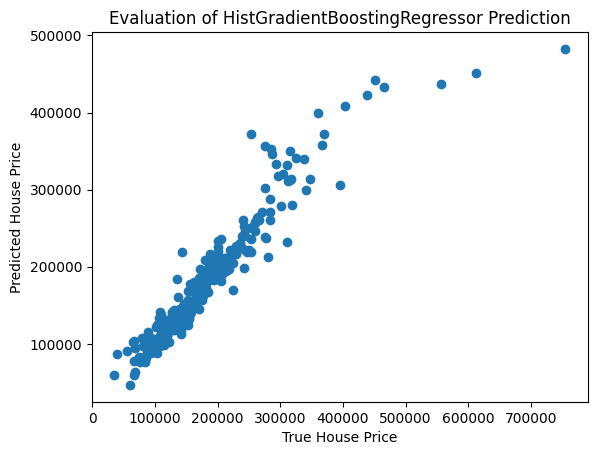

In [198]:
plt.scatter(np.exp(y_test), np.exp(test_pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of HistGradientBoostingRegressor Prediction')

In [199]:
with open(f'./{MODEL_OUTPUT_DIR}/hist_gradient_boosting_regressor.pkl', 'wb') as file:
    pickle.dump(model, file)

### 5. LGBMRegressor

In [200]:
def objective(trial):
    param_grid_ = {
        'random_state': RANDOM_SEED,
        'n_jobs': -1,
        'verbose': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 3000, 6000, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1.0),
    }

    # create a model with the params
    model = LGBMRegressor(**param_grid_)

    # KFold cross validations
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    rmse = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # fit the model
        model.fit(X_fold_train, y_fold_train)
        # predict
        y_pred = model.predict(X_fold_val)
        # calculate rmse
        fold_rmse = root_mean_squared_error(np.exp(y_fold_val), np.exp(y_pred))
        rmse.append(fold_rmse)
    return np.mean(rmse)

In [201]:
# create a study
study = optuna.create_study(
    study_name='lgbm_study',
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

try:
    study.optimize(objective, n_trials=20)
except:
    raise

[I 2025-02-17 20:59:26,759] A new study created in memory with name: lgbm_study
[I 2025-02-17 20:59:32,560] Trial 0 finished with value: 25773.06825163429 and parameters: {'num_leaves': 81, 'max_depth': 6, 'learning_rate': 0.028419391200547945, 'n_estimators': 5700, 'subsample': 0.34873826099889654, 'reg_alpha': 0.49431027465745775, 'reg_lambda': 0.03696993314927699, 'colsample_bytree': 0.4762734129045086}. Best is trial 0 with value: 25773.06825163429.
[I 2025-02-17 20:59:36,341] Trial 1 finished with value: 26752.871767005836 and parameters: {'num_leaves': 84, 'max_depth': 5, 'learning_rate': 0.08729168939047503, 'n_estimators': 5200, 'subsample': 0.647807642385308, 'reg_alpha': 1.3382001795086869, 'reg_lambda': 0.020718919540560442, 'colsample_bytree': 0.33987925020400583}. Best is trial 0 with value: 25773.06825163429.
[I 2025-02-17 20:59:45,358] Trial 2 finished with value: 29545.39861860759 and parameters: {'num_leaves': 125, 'max_depth': 3, 'learning_rate': 0.0012236740742794384

In [202]:
study.best_params

{'num_leaves': 59,
 'max_depth': 4,
 'learning_rate': 0.0032363809604766297,
 'n_estimators': 4800,
 'subsample': 0.10321049197362435,
 'reg_alpha': 0.04343040206432254,
 'reg_lambda': 0.01533724757935577,
 'colsample_bytree': 0.6139016807679636}

In [203]:
study.best_value

25250.82629321366

In [204]:
# save best params to json file
with open(f'./{MODEL_PARAM_DIR}/lgbm_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)

In [205]:
with open(f'./{MODEL_PARAM_DIR}/lgbm_params.json', 'r') as file:
    param_grid_ = json.load(file)

In [206]:
# train the model with best params
model = LGBMRegressor(
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=-1,
    **param_grid_
)

model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.6139016807679636,
              learning_rate=0.0032363809604766297, max_depth=4,
              n_estimators=4800, n_jobs=-1, num_leaves=59, random_state=42,
              reg_alpha=0.04343040206432254, reg_lambda=0.01533724757935577,
              subsample=0.10321049197362435, verbose=-1)

In [207]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

train rmse: 12628
train r2: 0.9732640975202183
train adjusted r2: 0.9717895133870658

test rmse: 28447
test r2: 0.8944970636188472
test adjusted r2: 0.8665158500568892



Text(0.5, 1.0, 'Evaluation of LGBMRegressor Prediction')

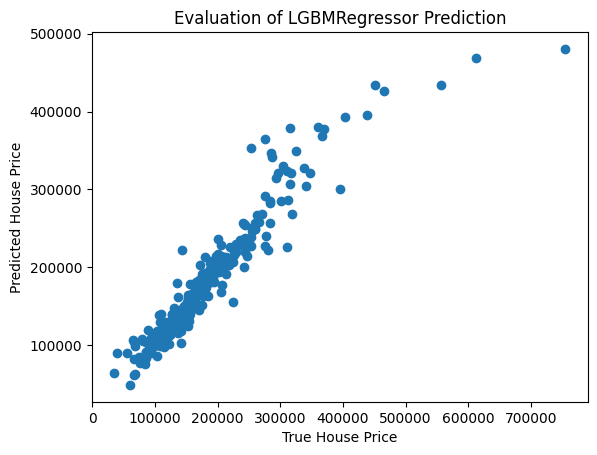

In [208]:
plt.scatter(np.exp(y_test), np.exp(test_pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of LGBMRegressor Prediction')

Text(0.5, 1.0, 'Feature Importance')

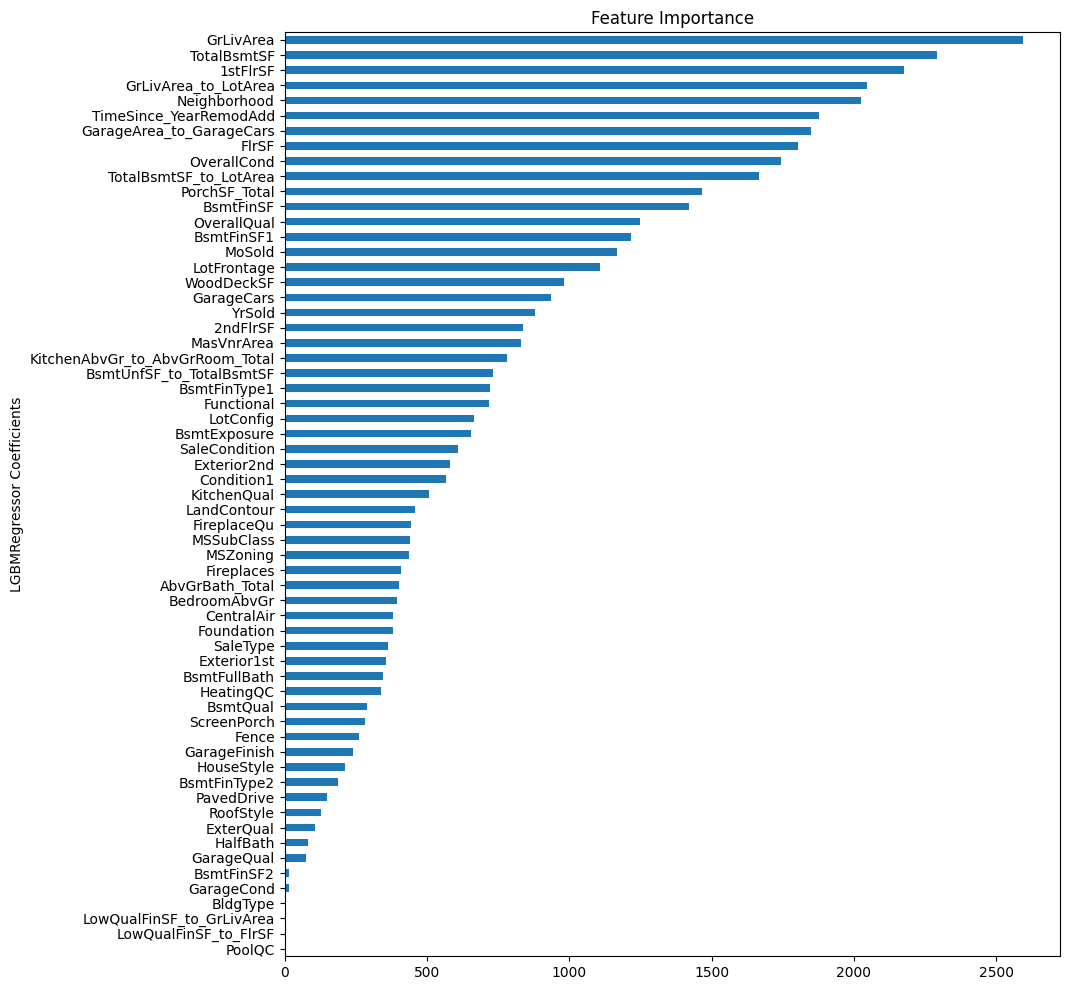

In [209]:
# check feature importance
importance = pd.Series(np.abs(model.feature_importances_.ravel()))
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=True)
importance.plot.barh(figsize=(10, 12))
plt.ylabel('LGBMRegressor Coefficients')
plt.title('Feature Importance')

In [210]:
with open(f'./{MODEL_OUTPUT_DIR}/lgbm_regressor.pkl', 'wb') as file:
    pickle.dump(model,file)

### 6. XGBRegressor

In [211]:
def objective(trial):
    param_grid_ = {
        'verbose':0,
        'random_seed': RANDOM_SEED,
        'n_jobs': -1,
        'max_depth': trial.suggest_int('depth', 4, 6),
        'max_leaves': trial.suggest_int('max_leaves', 32, 256, 16),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001, 0.002, 0.005, 0.008, 0.009, 0.01]),
        'n_estimators': trial.suggest_int('n_estimators', 3000, 5000, 50),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1.0),
        'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1.0, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1.0, 10.0),
    }

    # create a model with the params
    model = XGBRegressor(**param_grid_)

    # KFold cross validations
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    rmse = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # fit the model
        model.fit(X_fold_train, y_fold_train)
        # predict
        y_pred = model.predict(X_fold_val)
        # calculate rmse
        fold_rmse = root_mean_squared_error(np.exp(y_fold_val), np.exp(y_pred))
        rmse.append(fold_rmse)
    return np.mean(rmse)

In [212]:
# create a study
study = optuna.create_study(
    study_name='xgb_study',
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

try:
    study.optimize(objective, n_trials=20)
except:
    raise

[I 2025-02-17 21:04:31,918] A new study created in memory with name: xgb_study
[I 2025-02-17 21:04:37,885] Trial 0 finished with value: 51222.65596030177 and parameters: {'depth': 5, 'max_leaves': 112, 'learning_rate': 0.01, 'n_estimators': 3050, 'subsample': 0.12557270733318937, 'colsample_bytree': 0.34485315710748515, 'colsample_bylevel': 0.20964130807079404, 'reg_alpha': 7.592049412749509, 'reg_lambda': 3.530431880278353}. Best is trial 0 with value: 51222.65596030177.
[I 2025-02-17 21:04:46,565] Trial 1 finished with value: 30146.647489037998 and parameters: {'depth': 4, 'max_leaves': 144, 'learning_rate': 0.009, 'n_estimators': 4000, 'subsample': 0.9706410087550008, 'colsample_bytree': 0.908797647058648, 'colsample_bylevel': 0.20518615026206508, 'reg_alpha': 4.377420690909761, 'reg_lambda': 1.1645998213099242}. Best is trial 1 with value: 30146.647489037998.
[I 2025-02-17 21:04:57,966] Trial 2 finished with value: 32956.530015700795 and parameters: {'depth': 4, 'max_leaves': 160, 

In [213]:
study.best_params

{'depth': 5,
 'max_leaves': 48,
 'learning_rate': 0.005,
 'n_estimators': 4250,
 'subsample': 0.6754637218321198,
 'colsample_bytree': 0.5458944610008548,
 'colsample_bylevel': 0.4143938407207768,
 'reg_alpha': 1.460406867633603,
 'reg_lambda': 2.4060061976250924}

In [214]:
study.best_value

26996.80021673478

In [215]:
# save best params to json file
with open(f'./{MODEL_PARAM_DIR}/xgboost_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)

In [216]:
with open(f'./{MODEL_PARAM_DIR}/xgboost_params.json', 'r') as file:
    param_grid_ = json.load(file)

In [217]:
# train the model with best params
model = XGBRegressor(
    random_state=RANDOM_SEED,
    verbose=0,
    n_jobs=-1,
    **param_grid_
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4143938407207768, colsample_bynode=None,
             colsample_bytree=0.5458944610008548, depth=5, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.005, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=48, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=4250,
             n_jobs=-1, num_parallel_tree=None, ...)

In [218]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

train rmse: 16676
train r2: 0.9533759355545044
train adjusted r2: 0.9508044455624833

test rmse: 29446
test r2: 0.8869571685791016
test adjusted r2: 0.8569762437239937



Text(0.5, 1.0, 'Evaluation of XGBRegressor Prediction')

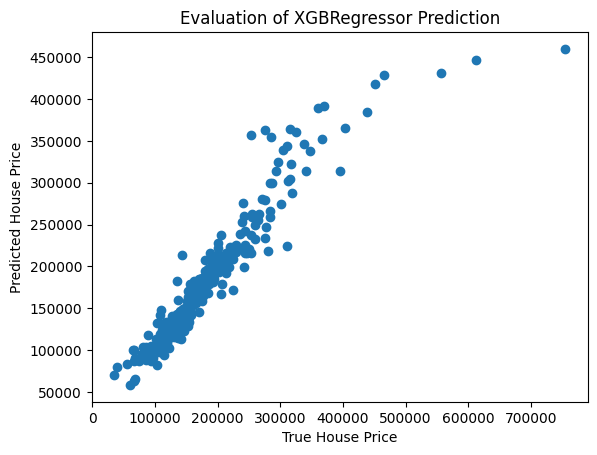

In [219]:
plt.scatter(np.exp(y_test), np.exp(test_pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of XGBRegressor Prediction')

Text(0.5, 1.0, 'Feature Importance')

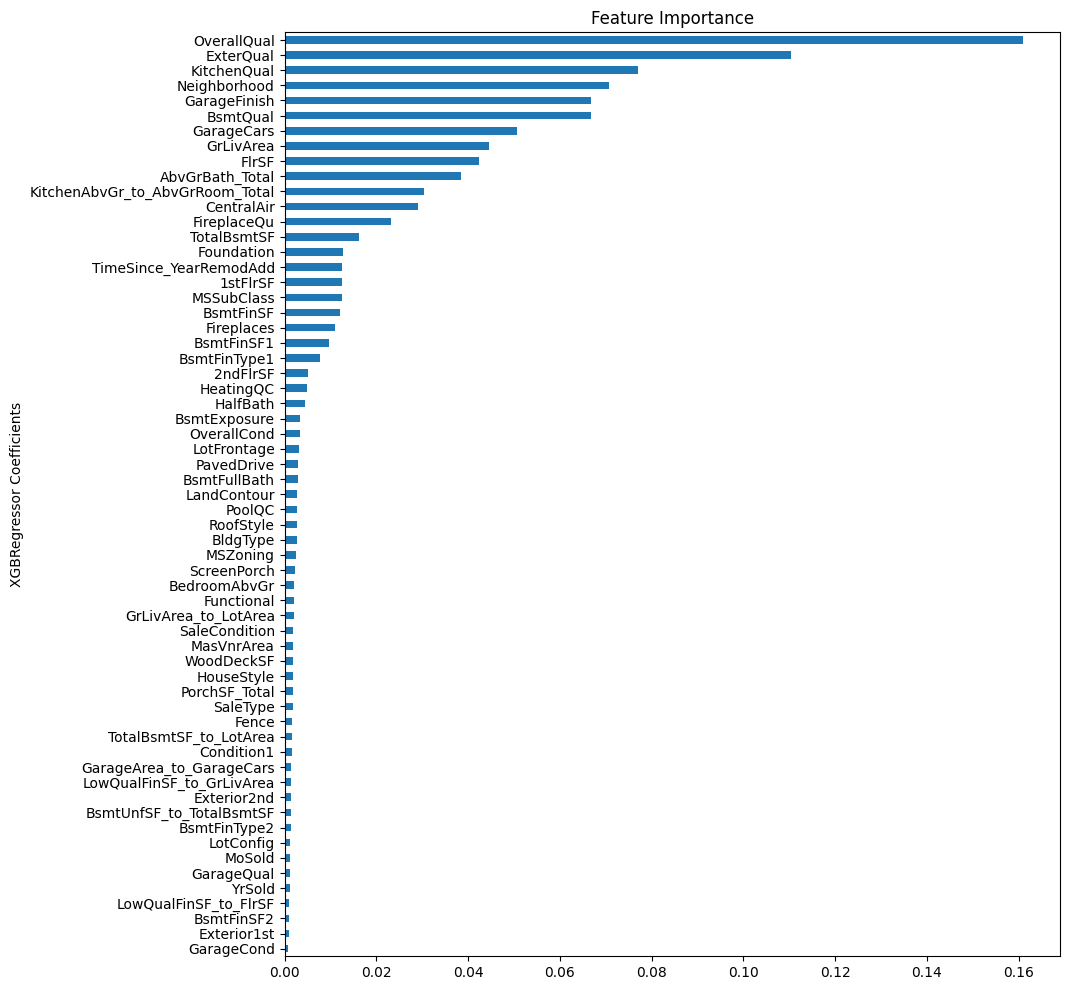

In [220]:
# check feature importance
importance = pd.Series(np.abs(model.feature_importances_.ravel()))
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=True)
importance.plot.barh(figsize=(10, 12))
plt.ylabel('XGBRegressor Coefficients')
plt.title('Feature Importance')

In [221]:
with open(f'./{MODEL_OUTPUT_DIR}/xgb_regressor.pkl', 'wb') as file:
    pickle.dump(model, file)

### 7. CatBoostRegressor

Since our dataset has many categorical variables, let's also try using CatBoostRegressor.

In [249]:
def objective(trial):
    param_grid_ = {
        'verbose':0,
        'random_seed': RANDOM_SEED,
        'depth': trial.suggest_int('depth', 3, 6),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.009, 0.01, 0.02]),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 2.0, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 4000, 6000, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 8, 20, 2),
        'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.1, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
    }

    # create a model with the params
    model = CatBoostRegressor(**param_grid_)

    # KFold cross validations
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    rmse = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # fit the model
        model.fit(X_fold_train, y_fold_train)
        # predict
        y_pred = model.predict(X_fold_val)
        # calculate rmse
        fold_rmse = root_mean_squared_error(np.exp(y_fold_val), np.exp(y_pred))
        rmse.append(fold_rmse)
    return np.mean(rmse)

In [250]:
# create a study
study = optuna.create_study(
    study_name='cb_study',
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

try:
    study.optimize(objective, n_trials=30)
except:
    raise

[I 2025-02-17 21:31:02,462] A new study created in memory with name: cb_study
[I 2025-02-17 21:31:23,121] Trial 0 finished with value: 25348.683481152802 and parameters: {'depth': 3, 'learning_rate': 0.02, 'l2_leaf_reg': 5.045207815266695, 'n_estimators': 5150, 'min_data_in_leaf': 12, 'colsample_bylevel': 0.5341968001034977, 'subsample': 0.18391274226419052}. Best is trial 0 with value: 25348.683481152802.
[I 2025-02-17 21:31:56,361] Trial 1 finished with value: 25325.363134423627 and parameters: {'depth': 5, 'learning_rate': 0.009, 'l2_leaf_reg': 5.687438934782976, 'n_estimators': 5900, 'min_data_in_leaf': 16, 'colsample_bylevel': 0.19232588073266413, 'subsample': 0.14781587165182972}. Best is trial 1 with value: 25325.363134423627.
[I 2025-02-17 21:32:18,262] Trial 2 finished with value: 25284.3578655594 and parameters: {'depth': 4, 'learning_rate': 0.01, 'l2_leaf_reg': 6.421112508738456, 'n_estimators': 4000, 'min_data_in_leaf': 18, 'colsample_bylevel': 0.7193210991231735, 'subsampl

In [251]:
study.best_params

{'depth': 3,
 'learning_rate': 0.01,
 'l2_leaf_reg': 2.7114534043568246,
 'n_estimators': 5700,
 'min_data_in_leaf': 16,
 'colsample_bylevel': 0.1747717913285673,
 'subsample': 0.10344472783467457}

In [252]:
study.best_value

24651.710440431554

In [253]:
# save best params to json file
with open(f'./{MODEL_PARAM_DIR}/catboost_params_v2.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)

In [254]:
with open(f'./{MODEL_PARAM_DIR}/catboost_params_v2.json', 'r') as file:
    param_grid_ = json.load(file)

In [255]:
param_grid_

{'depth': 3,
 'learning_rate': 0.01,
 'l2_leaf_reg': 2.7114534043568246,
 'n_estimators': 5700,
 'min_data_in_leaf': 16,
 'colsample_bylevel': 0.1747717913285673,
 'subsample': 0.10344472783467457}

In [267]:
# train the model with best params
model = CatBoostRegressor(
    random_state=RANDOM_SEED,
    verbose=0,
    **param_grid_
)

model.fit(X_train, y_train)

In [268]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

train rmse: 15204
train r2: 0.9612399995341534
train adjusted r2: 0.9591022418231077

test rmse: 25151
test r2: 0.9175265564019629
test adjusted r2: 0.8956531648390053



There is less overfitting with the CatBoostRegressor compared with other gradient boosting algorithms. It also performed better on the test set than all the algorithms so far.

Text(0.5, 1.0, 'Evaluation of CatBoostRegressor Prediction')

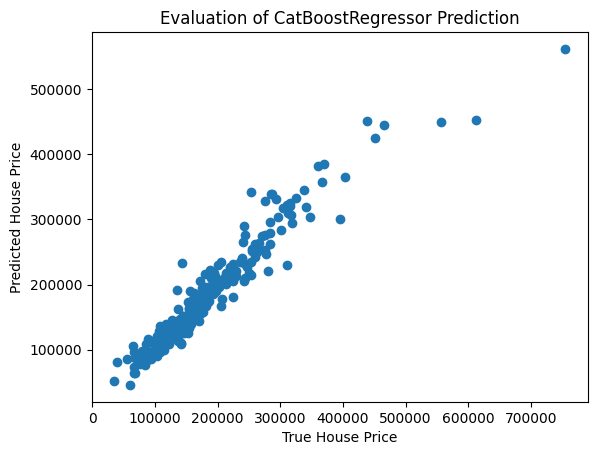

In [269]:
plt.scatter(np.exp(y_test), np.exp(test_pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of CatBoostRegressor Prediction')

Text(0.5, 1.0, 'Feature Importance')

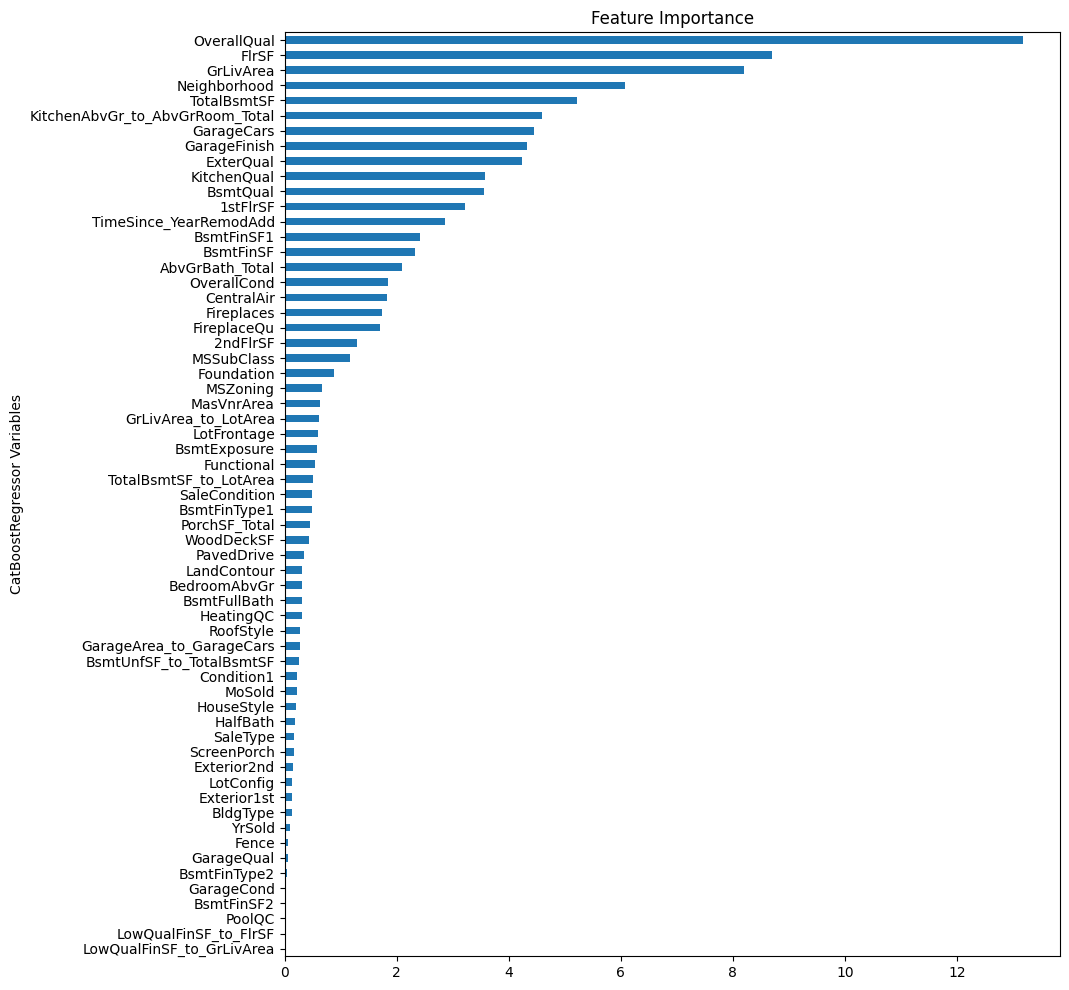

In [270]:
# check feature importance
importance = pd.Series(np.abs(model.feature_importances_.ravel()))
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=True)
importance.plot.barh(figsize=(10, 12))
plt.ylabel('CatBoostRegressor Variables')
plt.title('Feature Importance')

In [271]:
with open(f'./{MODEL_OUTPUT_DIR}/catboost_regressor_v2.pkl', 'wb') as file:
    pickle.dump(model, file)

The final model chosen for the submission will be the CatBoostRegressor.

### 8. Neural networks

Just for fun, I will also try a simple neural networks for prediction

In [15]:
# split the train data into a train and val set
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_SEED
)

In [23]:
# build the model with tensorflow functional API
#input
inputs = Input(shape=(X_train.shape[1],))
# hidden layers
x = Dense(16, activation='relu')(inputs)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = Dense(8, activation='relu')(x)
x = BatchNormalization()(x)
# output
outputs = Dense(1, activation='relu')(x)

model = Model(inputs=inputs, outputs=outputs)

In [24]:
# set up early stopping mechanism
early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=100, restore_best_weights=True)

# set up adam optimizers
optimizer_ = tf.keras.optimizers.Adam(0.09)

# compile the model
model.compile(optimizer=optimizer_, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [25]:
# train the model
r = model.fit(X_train_nn, y_train_nn, 
              epochs=1000, 
              batch_size=64, 
              validation_data=(X_val_nn, y_val_nn), 
              callbacks=early_stopping,
              )

Epoch 1/1000


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 94.0062 - root_mean_squared_error: 9.6275 - val_loss: 17706.9121 - val_root_mean_squared_error: 133.0673
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6247 - root_mean_squared_error: 1.2662 - val_loss: 1720.0625 - val_root_mean_squared_error: 41.4736
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3077 - root_mean_squared_error: 0.5494 - val_loss: 276.8576 - val_root_mean_squared_error: 16.6390
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0809 - root_mean_squared_error: 0.2838 - val_loss: 104.9148 - val_root_mean_squared_error: 10.2428
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543 - root_mean_squared_error: 0.2321 - val_loss: 48.3053 - val_root_mean_squared_error: 6.9502
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387 - root_mean_squared_error: 0.1966 - val_loss: 24.9541 - val_root_mean_squared_error: 4.9954
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

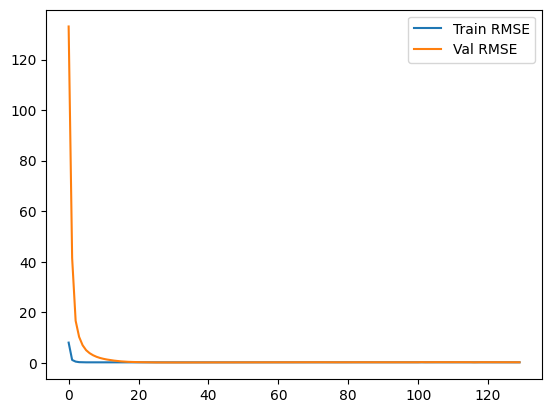

In [26]:
# plot the loss
plt.plot(r.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(r.history['val_root_mean_squared_error'], label='Val RMSE')
plt.legend()

In [27]:
# predictions & evaluations
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# determine rmse and r2 for train set
n, p = X_train.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_train), np.exp(train_pred))) * (n-1)/ (n-p-1))
print('train rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(train_pred))))
print(f'train adjusted r2: {adjusted_r2}')
print()


# determine mse, rmse and r2 for test set
n, p = X_test.shape
adjusted_r2 = 1 - ((1-r2_score(np.exp(y_test), np.exp(test_pred))) * (n-1)/ (n-p-1))
print('test rmse: {}'.format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(test_pred))))
print(f'test adjusted r2: {adjusted_r2}')
print()

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
train rmse: 29094
train r2: 0.8580783009529114
train adjusted r2: 0.8502507931392835

test rmse: 26926
test r2: 0.9054761528968811
test adjusted r2: 0.8804067847521408



In [28]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,605 (14.09 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 48 (192.00 B)

 Optimizer params: 2,372 (9.27 KB)

In [29]:
model.save('./model_output/mlp.keras')

## Submission

### 1. Load data and select features

In [287]:
# load the real test data
X_test = pd.read_csv('./processed_data/X_test.csv')

In [288]:
X_test.shape

(1459, 99)

In [289]:
X_test.head()

,MSZoning,Street,Alley,LandContour,LotConfig,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,Foundation,Heating,CentralAir,Electrical,FireplaceQu,GarageType,PavedDrive,MiscFeature,SaleType,SaleCondition,Neighborhood,Exterior1st,Exterior2nd,MSSubClass,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,GarageQual,GarageCond,PoolQC,LotShape,Utilities,LandSlope,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,GarageFinish,Fence,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,BsmtUnfSF_to_TotalBsmtSF,BsmtFinSF,BsmtFinSF_to_TotalBsmtSF,TotalBsmtSF_to_LotArea,FlrSF,LowQualFinSF_to_FlrSF,LowQualFinSF_to_GrLivArea,GrLivArea_to_FlrSF,GrLivArea_to_LotArea,BedroomAbvGr_to_AbvGrRoom_Total,KitchenAbvGr_to_AbvGrRoom_Total,PorchSF_Total,GarageArea_to_GarageCars,LotArea,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TimeSince_YearBuilt,TimeSince_YearRemodAdd,TimeSince_GarageYrBlt,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,MoSold,BsmtBath_Total,AbvGrBath_Total,AbvGrRoom_Total,QuSold
0,2,1,2,1,0,1,1,3,3,0,0,1,2,2,1,3,1,3,2,2,2,3,4,4,5,4,3,3,3,3,3,3,3,3,-1,4,4,1,1,3,2,8,1,3,0.546852,-0.818452,0.549525,-0.475482,-0.342653,-0.653100,-0.871454,-1.408075,1.152620,0.980706,-1.071307,-0.635324,0.632782,0.686856,-0.694450,-1.391642,-0.134652,-0.134652,-3.469447e-18,-1.607174,-0.155393,1.029057,-1.266998,3.621308,1,1,0,0,0,1,0,0,0.644928,0.183333,0.554545,1.0,0.360294,0.819672,0.457944,5,6,0.0,0.0,1,0,2,1,5,0,1.0,6,0.0,1,6,2
1,3,1,2,1,1,2,1,3,3,2,0,2,2,2,1,3,1,3,2,0,2,3,4,0,0,4,3,3,3,3,3,4,3,3,-1,3,4,1,1,5,1,8,1,-1,0.590269,1.109742,0.972297,-0.114082,0.650737,0.590073,-0.871454,-0.227707,-0.692405,1.295845,0.597468,-0.637285,0.898930,0.688587,-0.337859,-0.220174,-0.134652,-0.134652,-3.469447e-18,-1.203777,0.353702,-0.014653,0.186934,0.868081,1,0,0,0,0,0,0,1,0.623188,0.133333,0.527273,1.0,0.382353,0.868852,0.485981,6,6,0.0,0.0,1,1,3,1,6,0,1.0,6,0.0,2,8,2
2,3,1,2,1,0,2,1,3,5,0,0,1,4,2,1,3,3,3,2,2,2,3,7,4,5,6,3,3,4,3,4,3,3,3,-1,3,4,1,1,6,1,8,3,3,0.279518,-0.818452,0.870352,-0.941518,-0.235202,-0.540872,1.132148,0.382851,0.093744,1.110286,0.571252,-1.151098,0.795808,1.120444,-0.891714,0.390341,-0.134652,-0.134652,-3.469447e-18,-0.668148,-0.155393,-0.453115,0.157549,-0.453379,1,0,0,0,0,0,0,0,0.905797,0.800000,0.881818,1.0,0.095588,0.213115,0.121495,5,5,0.0,0.0,2,1,3,1,6,1,2.0,3,0.0,3,9,1
3,3,1,2,1,0,2,1,3,5,0,0,2,4,2,1,3,4,3,2,2,2,3,7,4,5,6,3,3,3,3,5,4,3,3,-1,3,4,1,1,6,1,8,3,-1,0.459068,0.664700,0.698615,-0.322538,-0.239844,-0.547763,1.125618,0.336431,0.040208,1.269999,0.597468,-0.500486,0.622660,0.566409,-0.344667,0.343815,-0.134652,-0.134652,-3.469447e-18,0.071904,-0.556405,-0.843906,0.186934,-0.598835,1,0,0,0,0,0,0,0,0.913043,0.800000,0.890909,1.0,0.088235,0.213115,0.112150,6,6,0.0,0.0,2,1,3,1,7,1,2.0,6,0.0,3,10,2
4,3,1,2,3,0,2,1,4,3,0,0,1,4,2,1,3,1,3,2,2,2,3,10,2,2,5,4,3,4,3,5,4,3,3,-1,3,4,1,1,5,1,8,2,-1,-1.355641,-0.818452,0.239162,1.005697,0.546666,0.473274,-0.871454,-0.340311,0.200072,-0.950337,0.980550,0.724841,0.163279,-0.677376,1.687323,-0.332430,-0.134652,-0.134652,-3.469447e-18,1.119117,-0.726545,0.477718,0.645278,-0.181765,1,0,0,0,0,1,0,0,0.869565,0.700000,0.836364,1.0,0.132353,0.311475,0.168224,8,5,0.0,0.0,2,0,2,1,5,0,2.0,1,0.0,2,7,1


In [290]:
# get the ids
ids_ = pd.read_csv('./test.csv', usecols=['Id'])

In [291]:
# check for null values
[col for col in X_test.columns if X_test[col].isnull().sum() > 0] 

[]

In [292]:
X_test.dtypes

MSZoning                             int64
Street                               int64
Alley                                int64
LandContour                          int64
LotConfig                            int64
Condition1                           int64
Condition2                           int64
BldgType                             int64
HouseStyle                           int64
RoofStyle                            int64
RoofMatl                             int64
MasVnrType                           int64
Foundation                           int64
Heating                              int64
CentralAir                           int64
Electrical                           int64
FireplaceQu                          int64
GarageType                           int64
PavedDrive                           int64
MiscFeature                          int64
SaleType                             int64
SaleCondition                        int64
Neighborhood                         int64
Exterior1st

In [293]:
# feature selection
with open('./feature_selection/feature_selection_lasso.pkl', 'rb') as file:
    sel_ = pickle.load(file)

In [294]:
X_test = sel_.transform(X_test)

In [295]:
X_test.shape

(1459, 61)

### 2. Make predictions

In [296]:
# make predictions - load the best model
with open(f'./{MODEL_OUTPUT_DIR}/catboost_regressor.pkl', 'rb') as file:
    model = pickle.load(file)

preds = model.predict(X_test)

In [ ]:
# parameters of the final model
model.get_params()

{'learning_rate': 0.01,
 'depth': 3,
 'l2_leaf_reg': 2.975141396023828,
 'loss_function': 'RMSE',
 'verbose': 0,
 'subsample': 0.10475507925692189,
 'n_estimators': 6000,
 'colsample_bylevel': 0.16279147115191916,
 'random_state': 42,
 'min_data_in_leaf': 10}

In [297]:
preds

array([11.69528756, 11.98120336, 12.11612489, ..., 12.01917894,
       11.69606902, 12.25314674])

In [298]:
preds = pd.Series(preds.reshape(-1)).apply(np.exp)      # reverse the log
preds = pd.concat([ids_, preds], axis=1)
preds.columns = ['Id', 'SalePrice']
preds.head()

,Id,SalePrice
0,1461,120004.864832
1,1462,159724.120755
2,1463,182795.787430
3,1464,192835.727925
4,1465,197792.627100


In [299]:
MODEL_PRED_DIR = 'predictions'
os.makedirs(MODEL_PRED_DIR, exist_ok=True)

In [300]:
preds.to_csv(f'./{MODEL_PRED_DIR}/submission_catboost.csv', index=False)

In [301]:
# make submission
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f ./predictions/submission_catboost.csv -m "Final submission"

Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/35.1k [00:00<?, ?B/s]
100%|██████████| 35.1k/35.1k [00:00<00:00, 73.8kB/s]
